# Imports

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from lifelines import CoxPHFitter,KaplanMeierFitter
import time
import requests
import sys
import pickle
import dill
import sqlite3
import http.cookiejar
import json
import matplotlib
import matplotlib.pyplot as plt
from pymatch.Matcher import Matcher
import math
import warnings
import matplotlib.gridspec as gridspec
from IPython.core.display import display, HTML
from scipy import interpolate
from patsy import dmatrix
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines.utils import interpolate_at_times_and_return_pandas
from tableone import tableone
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
warnings.filterwarnings('ignore')

/tmp/ipykernel_202447/427173159.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Downloading RSClin Scores

This code allows for downloading of the RSClin scores from the genomichealth website. JSESSIONID must be recorded from an active session in firefox while logged into the website. The cookie directory must also be updated with an individual's cookie directory.

In [203]:
jsessionID = "10E0C466E2166D980EF1C9BC6638FFE5"
cookies_dir = "C:\\Users\\fhowa\\AppData\\Roaming\\Mozilla\\Firefox\\Profiles\\7s8r0vbs.default-release\\cookies.sqlite"

def get_cookies(cj, ff_cookies):
    """Get cookies from firefox

    Parameters
    ----------
    cj - cookiejar
    ff_cookies - location of firefox cookies.sqlite file
    jsessionID - JSESSIONID variable from active session
    """
    con = sqlite3.connect(ff_cookies)
    cur = con.cursor()
    cur.execute("SELECT host, path, isSecure, expiry, name, value FROM moz_cookies")
    addedSession = False
    for item in cur.fetchall():
        c = http.cookiejar.Cookie(0, item[4], item[5],
                             None, False,
                             item[0], item[0].startswith('.'), item[0].startswith('.'),
                             item[1], False,
                             item[2],
                             item[3], item[3] == "",
                             None, None, {})
        cj.set_cookie(c)
        if not addedSession and item[0] == 'rsclin.genomichealth.com':
            c = http.cookiejar.Cookie(0, "JSESSIONID", jsessionID,
                                      None, False,
                                      item[0], item[0].startswith('.'), item[0].startswith('.'),
                                      item[1], False,
                                      item[2],
                                      item[3], item[3] == "",
                                      None, None, {})

            cj.set_cookie(c)


def loadCookiesFresh():
    """Load cookies from firefox

    Returns
    ----------
    Session s with cookies loaded
    """

    cj = http.cookiejar.CookieJar()
    ff_cookies = cookies_dir
    get_cookies(cj, ff_cookies)
    s = requests.Session()
    s.cookies = cj
    return s

def loadCookiesSaved():
    """Load cookies from saved file, external from firefox

    Returns
    ----------
    Session s with cookies loaded
    """
    s = requests.Session()
    with open('cookiefile', 'rb') as f:
        s.cookies.update(dill.load(f))
        f.close()
    return s

def saveCookies(s):
    """Save cookies to file, external from firefox

    Parameters
    ----------
    Session s with cookies loaded
    """
    with open('cookiefile', 'wb') as f:
        dill.dump(s.cookies, f)
        f.close()

def refreshCookies():
    """Load cookies from firefox and save to external file
    """
    s = loadCookiesFresh()
    saveCookies(s)

def getRSClin(age, grade, tumorsize, RS):
    """Get RSClin score from online calculator

    Parameters
    ----------
    age - patient age
    grade - tumor grade
    tumorsize - tumor size
    RS - recurrence score

    Returns
    ----------
    JSON format data with calculator results
    """
    s = loadCookiesSaved()
    params = {
        'tumorGrade':grade,
        'tumorSize':tumorsize,
        'treatment':'AROMATASE_INHIBITOR',
        'age':age,
        'rs':RS
    }
    header = {'Accept': 'application/json, text/plain, */*',
         'Accept-Encoding':	'gzip, deflate, br',
         'Accept-Language':	'en-US,en;q=0.5',
         'Referer': 'https://rsclin.genomichealth.com/',
         'Host': 'rsclin.genomichealth.com',
         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0',
         }
    s.headers.update(header)
    data = {'params': params}
    pr = requests.Request('GET', 'https://rsclin.genomichealth.com/api/v1/rspcCalculation', params=params)
    prepped = s.prepare_request(pr)
    def format_prepped_request(prepped, encoding=None):
        encoding = encoding or requests.utils.get_encoding_from_headers(prepped.headers)
        body = ""
        headers = '\n'.join(['{}: {}'.format(*hv) for hv in prepped.headers.items()])
        return f"""\
        {prepped.method} {prepped.path_url} HTTP/1.1
        {headers}
        
        {body}"""
    r = s.send(prepped, verify=False)
    saveCookies(s)
    return r.text

def createRSClinFile(NCDBfilename = 'NCDB2017.csv', RSClinfilename = 'RSClinScores2017_2.csv'):
    """Create blank file to store RSClin results

        Parameters
        ----------
        NCDBfilename - filename used to load NCDB data (must previously been saved)
        RSClinfilename - filename where to save the new RSClin file
        """
    df = load_data(NCDBfilename, savefile=False, loadfile=True)
    df['combined'] = df['age'].astype(str) + "," + df['grade'].astype(str) + "," + df['tumor_size'].astype(str) + "," + \
                     df['recurrence_score'].astype(str)
    print(len(df['combined'].unique()))
    dfbase = []
    for st in df['combined'].unique():
        sp = st.split(",")
        dfbase += [[sp[0], sp[1], str(round(int(sp[2]) / 10, 1)), str(int(float(sp[3])))]]
    dfb = pd.DataFrame(dfbase)
    dfb.columns = ['age', 'grade', 'tumor_size', 'rs']
    dfb['result'] = ""
    dfb.to_csv(RSClinfilename, index=False)


def populateRSClinFile(RSClinfilename = 'RSClinScores2017_3.csv', lb = 0, ub = 76502):
    """Create blank file to store RSClin results

        Parameters
        ----------
        RSClinfilename - filename of the blank RSClin file from createRSClinFile function
        lb = lower bound of rows from which to get RSClin scores
        ub = upper bound of rows from which to get RSClin scores
        """
    refreshCookies()
    df = pd.read_csv(RSClinfilename, dtype=str)
    df = df.fillna('')
    for index, row in df.iterrows():
        if index >= lb and index <= ub:
            if row['result'] == "" or "html" in row['result']:
                df.loc[df.index == index, "result"] = getRSClin(age = row['age'], grade= row['grade'], tumorsize=row['tumor_size'], RS=row['rs'])
                print(index, df.loc[df.index == index, "result"])
                if 'html' in df.loc[df.index == index, "result"]:
                    # Indicates the process has failed.
                    df.to_csv(RSClinfilename, index=False)
                    exit(0)
    df.to_csv(RSClinfilename, index=False)
                    
def processRSClin(RSClinfilename = 'RSClinScores2017_2.csv', processed_filename = 'RSClinScores_process2017.csv'):
    """Process RSClin file JSON into text

        Parameters
        ----------
        RSClinfilename - filename of the raw RSClin file from populateRSClinFile function
        processed_filename - filename for processed output data
        """
    df = pd.read_csv(RSClinfilename, dtype=str)
    for index, row in df.iterrows():
        res = json.loads(row['result'])
        for key, value in res.items():
            if key not in ['age', 'grade', 'tumor_size', 'rs', 'id', 'tumorGrade', 'tumorSize', 'recurrenceScore']:
                df.loc[df.index == index, key] = value
    df.to_csv(processed_filename, index=False)

In [204]:
#Create blank file to store RSClin scores
createRSClinFile('NCDB2020.csv', 'RSClinScores2020.csv')

#Populate RSClin file from genomichealth - JSessionID must be properly stored
populateRSClinFile('RSClinScores2020.csv')

#Process the JSON results into comma seperated values
processRSClin('RSClinScores2020.csv', 'RSClinScores_process2020.csv')

# Data Loading from NCDB
Load data from NCDB with option to store in file for further processing.

First step is to properly load the NCDB file.

Since loading the full NCDB csv takes quite some time, you can utilize the savefile and loadfile specifications to save a subset of the database once you've narrowed down to the patients / variables you are interested in.

This next cell defines a 'function', we can then call the function later on in this notebook to get the actual results, running the code below just defines (as per def) the function. The function's name is load_data_her2. After the function, we specify parameters (filename, savefile, loadfile, and lower). You can provide default values for these parameters if you want using the equals sign - this means that the user doesn't need to provide these parameters every time the function is called.

Detailed descriptions of all NCDB elements are found here:
<a href="https://www.facs.org/-/media/files/quality-programs/cancer/ncdb/puf_data_dictionary_2017.ashx">https://www.facs.org/-/media/files/quality-programs/cancer/ncdb/puf_data_dictionary_2017.ashx</a>

'Site Specific Factors' are found here:
<a href="https://web2.facs.org/cstage0205/breast/Breastschema.html">https://web2.facs.org/cstage0205/breast/Breastschema.html</a>

In [6]:
diffCount = -1

def addPropensityColumn(df, columns, name):
    df[name] = np.nan
    clf = LogisticRegression()
    clf.fit(df.loc[~df[columns].isnull().T.any(), columns], df.loc[~df[columns].isnull().T.any(), 'chemo'])
    df.loc[~df[columns].isnull().T.any(), name] = clf.predict_proba(df.loc[~df[columns].isnull().T.any(), columns])[:, 1]
    df[name] = df.chemo / df[name] + (1 - df.chemo)/(1 - df[name])
    return df
    
    #Calculates inverse probability of treatment weighting scores using covariates listed in 'columns'. 
    c0 = df[df.chemo == 0]
    c1 = df[df.chemo == 1]
    print(c0[columns].describe())
    print(c1[columns].describe())
    pmatchColumns = columns + ['chemo']
    print(c0.describe().to_string())

    c0 = c0[pmatchColumns]
    c1 = c1[pmatchColumns]
    m = Matcher(c0, c1, yvar='chemo', exclude=[item for item in df.columns.tolist() if item not in pmatchColumns])
    print(len(m.data.index))
    m.fit_scores(balance=True, nmodels=100)
    m.predict_scores()
    # Code to graph propensity scores
    # m.plot_scores()
    # m.match(method="min", nmatches=1, threshold=0.0001)
    # m.assign_weight_vector()
    # plt.show()

    # Calculate IPTW weight
    df = m.data
    df[name] = df.chemo / df.scores + (1 - df.chemo) / (1 - df.scores)
    return df

def dfCount(df, callout):
    #Prints a description of patients remaining / excluded in dataframe while loading
    global diffCount
    print(callout + ": " + str(len(df.index)))
    if diffCount > -1:
        print(callout + " (diff): " + str(diffCount - len(df.index)))
    diffCount = len(df.index)



def load_data_2020(filename=None, savefile=None, loadfile=None, lower=True):
    """Load data from NCDB and print # excluded at each step

     Parameters
     ----------
     filename - name of csv NCDB PUF file
     savefile - Provide a string if you want to save the resultant dataframe as CSV (saves as 'saved_' + savefile)
     loadfile - Provide a string if you want to load a cleaned NCDB dataframe (from 'saved_' + loadfile)
     lower - True if the column headers need to be lowercase (NCDB 2017 switched from uppercase to lowercase)

     Returns
     -------
     dataframe with loaded NCDB dataset
     """
    if loadfile:
        return pd.read_csv(filename, dtype=str)
    
    #This next line specifies the columns from NCDB to load. These need to be in the same order as they are listed in NCDB
    fields = ['facility_type_cd', 'AGE', 'sex', 'RACE', 'spanish_hispanic_origin', 'insurance_status', 'cdcc_total_best', 'year_of_diagnosis', 'laterality', 'histology', 'behavior', 
              'GRADE', 'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'TNM_CLIN_T', 'TNM_CLIN_N', 'TNM_CLIN_M', 'tnm_clin_stage_group', 'TNM_PATH_T', 'TNM_PATH_N', 'TNM_PATH_M', 
              'tnm_path_stage_group', 'analytic_stage_group', 'cs_mets_dx_bone', 'cs_mets_dx_brain', 'cs_mets_dx_liver', 'cs_mets_dx_lung', 'lymph_vascular_invasion', 'CS_SITESPECIFIC_FACTOR_8', 'CS_SITESPECIFIC_FACTOR_10', 'CS_SITESPECIFIC_FACTOR_12', 
              'CS_SITESPECIFIC_FACTOR_15', 'CS_SITESPECIFIC_FACTOR_16', 'CS_SITESPECIFIC_FACTOR_21', 'CS_SITESPECIFIC_FACTOR_22', 'CS_SITESPECIFIC_FACTOR_23', 'dx_defsurg_started_days', 'dx_chemo_started_days', 'RX_SUMM_CHEMO', 'dx_hormone_started_days', 'RX_SUMM_HORMONE', 
              'DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS', 'tumor_size_summary_2016', 'mets_at_dx_bone', 'mets_at_dx_brain', 'mets_at_dx_liver', 'mets_at_dx_lung',  'ajcc_tnm_clin_n', 'ajcc_tnm_clin_stg_grp', 'ajcc_tnm_clin_t', 
              'ajcc_tnm_path_n', 'ajcc_tnm_path_stg_grp', 'ajcc_tnm_path_t', 'ajcc_tnm_post_path_n', 'ajcc_tnm_post_path_t', 'er_percent_pos_or_rng', 'er_summary',  'grade_clin', 'grade_path',  'her2_ihc_summary', 
              'her2_ish_dual_num', 'her2_ish_dual_ratio', 'her2_ish_single_num', 'her2_overall_summ', 'ki67', 'oncotype_risk_invas', 'oncotype_score_inv', 'pr_percent_pos_or_rng', 'pr_summary']
    #Since the column names are confusing, we provide a list of shorter names to be used
    fieldname = ['facility', 'age', 'sex', 'race', 'hispanic', 'insurance', 'cdcc', 'year', 'laterality', 'histology', 'behavior', 
                 'grade', 'tumor_size', 'regional_nodes_positive', 'tnm_clin_t', 'tnm_clin_n', 'tnm_clin_m', 'tnm_clin_stage_group', 'tnm_path_t', 'tnm_path_n', 'tnm_path_m', 
                 'tnm_path_stage_group', 'stage', 'mets_bone', 'mets_brain', 'mets_liver', 'mets_lung', 'lvi', 'her2', 'her2ratio', 'her2copies', 
                 'her2sum', 'receptors', 'neoadj_response', 'recurrence_assay', 'recurrence_score', 'surg_days', 'chemo_days', 'rx_summ_chemo', 'hormone_days', 'rx_summ_hormone', 
                 'last_contact', 'alive',  'tumor_size_summary_2016', 'mets_at_dx_bone', 'mets_at_dx_brain', 'mets_at_dx_liver', 'mets_at_dx_lung', 'ajcc_tnm_clin_n', 'ajcc_tnm_clin_stg_grp', 'ajcc_tnm_clin_t', 
                 'ajcc_tnm_path_n', 'ajcc_tnm_path_stg_grp', 'ajcc_tnm_path_t', 'ajcc_tnm_post_path_n', 'ajcc_tnm_post_path_t', 'er_percent', 'er_summary', 'grade_clin', 'grade_path', 'her2_ich_summary', 
                 'her2_ish_dual_num', 'her2_ish_dual_ratio', 'her2_ish_single_num', 'her2_overall_summ',  'ki67', 'oncotype_risk_invas', 'oncotype_score_inv', 'pr_percent', 'pr_summary']

    #This converts the words in the 'fields' variable to lowercase
    if lower:
        fields = [f.lower() for f in fields]
    
    #This actually reads the CSV file
    df = pd.read_csv(filename, usecols=fields, dtype=str)

    
    #We set the column names within the CSV file to the simpler names
    df.columns = fieldname
    
    
   
    print("Total Patients in NCDB: " + str(len(df.index)))
    
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df[df.year >= 2010]
    print("Excluding diagnoses before 2010: " + str(len(df.index)))

    
    df['odx'] = np.nan
    df.loc[(df.recurrence_assay.astype(float) == 10) & (df.recurrence_score.astype(float) < 101), 'odx'] = df.recurrence_score.astype(float)
    df['oncotype_risk_invas'] = pd.to_numeric(df.oncotype_risk_invas, errors = 'coerce')
    df['oncotype_score_inv'] = pd.to_numeric(df.oncotype_score_inv, errors = 'coerce')
    df.loc[(df.oncotype_risk_invas.astype(float).isin([0,1])), 'odx'] = df['oncotype_score_inv'].astype(float)
    df = df[~df.odx.isna()]
    df['recurrence_score'] = df['odx']
    print("Excluding those with uknown Oncotype: " + str(len(df.index)))
    
    
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df.loc[df.age > 90, 'age'] = np.nan

    df['sex'] = pd.to_numeric(df['sex'], errors='coerce')
    df.loc[~df.sex.isin([1,2]), 'sex'] = np.nan
    
    df['cdcc'] = pd.to_numeric(df['cdcc'], errors='coerce')
    df.loc[~df.cdcc.isin([0,1,2,3]), 'cdcc'] = np.nan

    
    df['race'] = pd.to_numeric(df['race'], errors='coerce')
    df['hispanic'] = pd.to_numeric(df['hispanic'], errors='coerce')

    df['insurance_parse'] = np.nan #private
    df.loc[df.insurance.astype(float).isin([1]), 'insurance_parse'] = 0
    df.loc[df.insurance.astype(float).isin([0,2,3,4]), 'insurance_parse'] = 1  # public / uninsured
    
    
    
    df['race_parse'] = np.nan 
    df.loc[((df.race == 1) & (df.hispanic == 0)), 'race_parse'] = 0 #non-hispanic white
    df.loc[((df.race == 2) & (df.hispanic == 0)), 'race_parse'] = 1 #non-hispanic black
    df.loc[(df.hispanic > 0) & (df.hispanic < 9), 'race_parse'] = 2  # hispanic
    df.loc[((df.race == 98) & (df.hispanic == 0)), 'race_parse'] = 3 #other
    df.loc[((df.race == 3) & (df.hispanic == 0)), 'race_parse'] = 4 #Native american
    df.loc[((~df.race.isin([0,1,2,3,98,99])) & (df.hispanic == 0)), 'race_parse'] = 5 #asian / pacific islander
    df.loc[(~df.race.isin([0,1,2,3,98,99, np.nan])) & (df.hispanic == 0), 'race_parse'] = 5 #asian / pacific islander
    df.loc[df.race == 99, 'race_parse'] = np.nan #unknown race (we will ignore unknown ethnicity)
    
    df['race_asian'] = 0
    df.loc[df.race_parse == 5, 'race_asian'] = 1
    df['race_black'] = 0
    df.loc[df.race_parse == 1, 'race_black'] = 1
    df['race_hispanic'] = 0
    df.loc[df.race_parse == 2, 'race_hispanic'] = 1
    df['race_other'] = 0
    df.loc[(df.race_parse > 2), 'race_other'] = 1 #Non white / black / hispanic for propensity matching
    
    
    df['histology'] = pd.to_numeric(df['histology'], errors='coerce')  
    
    df.loc[df.histology.isin([8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8523, 8230]), 'histology'] = 0 #ductal

    df.loc[df.histology.isin([8520, 8521, 8524, 8525]), 'histology'] = 1 #lobular
    df.loc[df.histology.isin([8522]), 'histology'] = 2 # mixed
    df.loc[df.histology.isin([8480, 8481]), 'histology'] = 3 # mucinous
    df.loc[df.histology.isin([8503, 8504, 8260, 8050, 8051, 8052]), 'histology'] = 4 # papillary
    df.loc[df.histology.isin([8211, 8210]), 'histology'] = 5 # tubular
    df.loc[df.histology.isin([8530]), 'histology'] = 6 # inflammatory
    df.loc[df.histology.isin([8510, 8512, 8513, 8514]), 'histology'] = 7 # medullary
    df.loc[df.histology.isin([8570, 8571, 8572, 8573, 8574, 8575, 8576]), 'histology'] = 8 # metaplsatic
    df.loc[df.histology.isin([8540, 8541, 8542, 8543]), 'histology'] = 9 # paget
    df.loc[(df.histology >= 8800) & (df.histology <= 9581), 'histology'] = 10 # sarcoma, etc    
    df.loc[~df.histology.isin([0,1,2,3,4,5,6,7,8,9,10,np.nan]), 'histology'] = 11 #other
    df = df[df.behavior.astype(float) == 3]
    print("Excluding non-invasive cases: " + str(len(df.index)))
    
    df['grade'] = pd.to_numeric(df['grade'], errors='coerce')  
    df.loc[df.grade == 4] = 3
    df.loc[~df.grade.astype(float).isin([1,2,3]), 'grade'] = np.nan
    
        
    #fix for later year of diagnosis:
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_clin.isin(['H','3','C','D'])), 'grade'] = 3
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_clin.isin(['M','2','B'])), 'grade'] = 2
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_clin.isin(['L','1','A'])), 'grade'] = 1
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_path.isin(['H','3','C','D'])), 'grade'] = 3
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_path.isin(['M','2','B'])), 'grade'] = 2
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_path.isin(['L','1','A'])), 'grade'] = 1
    
    #Tumor size likely obsolete
    df.loc[df.year.astype(float) >= 2016, 'tumor_size'] = df['tumor_size_summary_2016']
    df['tumor_size'] = pd.to_numeric(df['tumor_size'], errors='coerce')  
    df.loc[df.tumor_size.astype(float) == 990, 'tumor_size'] = 1
    df.loc[df.tumor_size.astype(float) == 991, 'tumor_size'] = 5 # < 1 cm
    df.loc[df.tumor_size.astype(float) == 992, 'tumor_size'] = 15 # 1-2 cm
    df.loc[df.tumor_size.astype(float) == 993, 'tumor_size'] = 25 # 2-3 cm
    df.loc[df.tumor_size.astype(float) == 994, 'tumor_size'] = 35 # 3-4 cm
    df.loc[df.tumor_size.astype(float) == 995, 'tumor_size'] = 45 # 4-5 cm
    df.loc[df.tumor_size.astype(float) > 995, 'tumor_size'] = np.nan
    
    
    #probably need to just use TNM stage
    df['regional_nodes_positive'] = pd.to_numeric(df['regional_nodes_positive'], errors='coerce')  
    df.loc[df.regional_nodes_positive.astype(float).isin([98,99]), 'regional_nodes_positive'] = np.nan
    
    df['pcr'] = 0
    df.loc[((df.tnm_path_n.str.contains("p0")) | df.neoadj_response.astype(float).isin([10]) | (df.tnm_path_n.str.contains("pI"))) & ((df.tnm_path_t.str.contains("p0")) | (df.tnm_path_t.str.contains("pIS"))), 'pcr'] = 1
    df.loc[((df.neoadj_response.astype(float) > 30) | (df.neoadj_response.astype(float) == 25)) & (df.tnm_path_n.str.contains("88") | df.tnm_path_n.str.contains("pX") | df.tnm_path_t.str.contains("88") | df.tnm_path_t.str.contains("pX") | (df.tnm_path_t == "") | (df.tnm_path_n == "")), 'pcr'] = np.nan
    df.loc[(df.year.astype(float) >= 2018), 'pcr'] = 0
    df.loc[(df.year.astype(float) >= 2018) & (df.ajcc_tnm_post_path_n.str.contains('N0') & (df.ajcc_tnm_post_path_t.str.contains('T0') | df.ajcc_tnm_post_path_t.str.contains('Tis'))), 'pcr'] = 1
    df.loc[(df.year.astype(float) >= 2018) & (df.ajcc_tnm_post_path_n.str.contains('NX') | df.ajcc_tnm_post_path_t.str.contains('TX') | (df.ajcc_tnm_post_path_n == '') | (df.ajcc_tnm_post_path_t == '')), 'pcr'] = 1


    df.loc[(df.year.astype(float) >= 2018), 'mets_bone'] = df['mets_at_dx_bone']
    df.loc[(df.year.astype(float) >= 2018), 'mets_brain'] = df['mets_at_dx_brain']
    df.loc[(df.year.astype(float) >= 2018), 'mets_liver'] = df['mets_at_dx_liver']
    df.loc[(df.year.astype(float) >= 2018), 'mets_lung'] = df['mets_at_dx_lung']
    
    df['mets_bone'] = pd.to_numeric(df['mets_bone'], errors='coerce')  
    df['mets_brain'] = pd.to_numeric(df['mets_brain'], errors='coerce')  
    df['mets_liver'] = pd.to_numeric(df['mets_liver'], errors='coerce')  
    df['mets_lung'] = pd.to_numeric(df['mets_lung'], errors='coerce')  
    
    df.loc[(df.mets_bone.astype(float) > 2), 'mets_bone'] = np.nan
    df.loc[(df.mets_brain.astype(float) > 2), 'mets_brain'] = np.nan
    df.loc[(df.mets_liver.astype(float) > 2), 'mets_liver'] = np.nan
    df.loc[(df.mets_lung.astype(float) > 2), 'mets_lung'] = np.nan    
    
    df['receptors'] = pd.to_numeric(df['receptors'], errors='coerce')
    df.loc[df.receptors.astype(float) > 111, 'receptors'] = np.nan   
    df.pr_summary = pd.to_numeric(df.pr_summary, errors = 'coerce')
    df.er_summary = pd.to_numeric(df.er_summary, errors = 'coerce')
    df.loc[(df.pr_summary.isin([0,1])) & (df.er_summary.isin([0, 1])) & (df.her2_overall_summ.astype(float).isin([0,1])), 'receptors'] = df.er_summary.astype(float) * 100 + df.pr_summary.astype(float) * 10 + df.her2_overall_summ.astype(float)
    df = df[df.receptors.astype(float).isin([10,100,110,np.nan])]
    print("Excluding HER2+/TNBC: " + str(len(df.index)))
    
    df['er_num'] = pd.to_numeric(df['er_percent'], errors='coerce')
    df.loc[df.er_percent == 'R10', 'er_num'] = 5
    df.loc[df.er_percent == 'R20', 'er_num'] = 15
    df.loc[df.er_percent == 'R30', 'er_num'] = 25
    df.loc[df.er_percent == 'R40', 'er_num'] = 35
    df.loc[df.er_percent == 'R50', 'er_num'] = 45
    df.loc[df.er_percent == 'R60', 'er_num'] = 55
    df.loc[df.er_percent == 'R70', 'er_num'] = 65
    df.loc[df.er_percent == 'R80', 'er_num'] = 75
    df.loc[df.er_percent == 'R90', 'er_num'] = 85
    df.loc[df.er_percent == 'R99', 'er_num'] = 95

    df['pr_num'] = pd.to_numeric(df['pr_percent'], errors='coerce')
    df.loc[df.pr_percent == 'R10', 'pr_num'] = 5
    df.loc[df.pr_percent == 'R20', 'pr_num'] = 15
    df.loc[df.pr_percent == 'R30', 'pr_num'] = 25
    df.loc[df.pr_percent == 'R40', 'pr_num'] = 35
    df.loc[df.pr_percent == 'R50', 'pr_num'] = 45
    df.loc[df.pr_percent == 'R60', 'pr_num'] = 55
    df.loc[df.pr_percent == 'R70', 'pr_num'] = 65
    df.loc[df.pr_percent == 'R80', 'pr_num'] = 75
    df.loc[df.pr_percent == 'R90', 'pr_num'] = 85
    df.loc[df.pr_percent == 'R99', 'pr_num'] = 95
    
    df['ki67_num'] = pd.to_numeric(df['ki67'], errors='coerce')

        

    
    # Next, we want HER2 IHC to be 0+ to 2+ (3+ is positive). Technically this should be 0, 10, or 20, corresponding to
    # 0+, 1+, and 2+, if we again review the site specific factors (this time, site specific factor 8).
    # However, 1 and 2 used to signify 1+ and 2+, so I included these to catch a few patients who were miscoded
    
    df.loc[df.her2_ich_summary.astype(float).isin([0]), 'her2'] = 0
    df.loc[df.her2_ich_summary.astype(float).isin([1]), 'her2'] = 1
    df.loc[df.her2_ich_summary.astype(float).isin([2]), 'her2'] = 2
    df.loc[df.her2.astype(float) == 10, 'her2'] = 1
    df.loc[df.her2.astype(float) == 20, 'her2'] = 2
    #df = df[(df.her2.astype(float).isin([0, 1, 2]))]

    df['her2ratio'] = pd.to_numeric(df['her2ratio'], errors='coerce') 
    df.loc[df.her2ratio.astype(float).isin([981,982,983,984,985,986,987]), 'her2ratio'] = 980
    df.loc[df.her2ratio.astype(float).isin([991]), 'her2ratio'] = 100
    df.loc[df.her2ratio.astype(float).isin([988, 989, 990, 992, 993, 994, 995, 996, 997, 998, 999]), 'her2ratio'] = np.nan
    df.loc[df.her2ratio.astype(float) < 100, 'her2ratio'] = np.nan
    df['her2ratio'] = df['her2ratio'].astype(float)/100
    df['her2_ish_dual_ratio'] = pd.to_numeric(df['her2_ish_dual_ratio'], errors='coerce')
    df.loc[~df.her2_ish_dual_ratio.isna(), 'her2ratio'] = df['her2_ish_dual_ratio']
    
    df['her2copies'] = pd.to_numeric(df['her2copies'], errors='coerce')
    df.loc[df.her2copies.astype(float).isin([981,982,983,984,985,986,987]), 'her2copies'] = 980
    df.loc[df.her2copies.astype(float).isin([991]), 'her2copies'] = 100
    df.loc[df.her2copies.astype(float).isin([988, 989, 990, 992, 993, 994, 995, 996, 997, 998, 999]), 'her2copies'] = np.nan
    df.loc[df.her2copies.astype(float) < 100, 'her2copies'] = np.nan
    df['her2copies'] = df['her2copies'].astype(float)/100
    df['her2_ish_dual_num'] = pd.to_numeric(df['her2_ish_dual_num'], errors='coerce')
    df.loc[~df.her2_ish_dual_num.isna(), 'her2copies'] = df['her2_ish_dual_num']
    df['her2_ish_single_num'] = pd.to_numeric(df['her2_ish_single_num'], errors='coerce')
    df.loc[~df.her2_ish_single_num.isna(), 'her2copies'] = df['her2_ish_single_num']

    df['chemo'] = np.nan
    df.loc[df.rx_summ_chemo.astype(float).isin([1,2,3]), 'chemo'] = 1
    df.loc[df.rx_summ_chemo.astype(float).isin([0, 82, 85, 86, 87]), 'chemo'] = 0
                                                           
    df['hormone'] = np.nan
    df.loc[df.rx_summ_hormone.astype(float).isin([1]), 'hormone'] = 1
    df.loc[df.rx_summ_hormone.astype(float).isin([0, 82, 85, 86, 87]), 'hormone'] = 0

    #Excluding those without hormonal therapy / unknown chemotheapy status
    df = df[(df.hormone == 1) & df.chemo.isin([0,1])]
    print("Excluding those without hormonal / unknown chmeotherapy status: " + str(len(df.index)))

    df['surg_days'] = pd.to_numeric(df['surg_days'], errors='coerce')
    df['chemo_days'] = pd.to_numeric(df['chemo_days'], errors='coerce')
    df['hormone_days'] = pd.to_numeric(df['hormone_days'], errors='coerce')

    df['neoadj_chemo'] = np.nan
    df.loc[df['surg_days'] > df['chemo_days'] + 30, 'neoadj_chemo'] = 1
    df.loc[df['surg_days'] <= df['chemo_days'] + 30, 'neoadj_chemo'] = 0
    df.loc[df.neoadj_response.astype(float).isin([10,20,25,30]), 'neoadj_chemo'] = 1
    df.loc[df.neoadj_response.astype(float).isin([987, 998]), 'neoadj_chemo'] = 0
    df.loc[df.ajcc_tnm_post_path_t.str.contains('yp') | df.ajcc_tnm_post_path_n.str.contains('yp'), 'neoadj_chemo'] = 1
    df.loc[df.chemo == 0, 'neoadj_chemo'] = 0                                                         

    df['neoadj_endo'] = np.nan
    df.loc[df['surg_days'] > df['hormone_days'] + 30, 'neoadj_endo'] = 1
    df.loc[df['surg_days'] <= df['hormone_days'] + 30, 'neoadj_endo'] = 0
    df.loc[df.hormone == 0, 'neoadj_endo'] = 0

    df.loc[(df.neoadj_chemo == 1) & (df.neoadj_endo == 1), 'neoadj_endo'] = 0    

    df.loc[(df.year.astype(float) >= 2018), 'tnm_clin_stage_group'] = df['ajcc_tnm_clin_stg_grp']
    df.loc[(df.year.astype(float) >= 2018), 'tnm_path_stage_group'] = df['ajcc_tnm_path_stg_grp']
    df.loc[(df.year.astype(float) >= 2018), 'tnm_clin_t'] = df['ajcc_tnm_clin_t']
    df.loc[(df.year.astype(float) >= 2018), 'tnm_path_t'] = df['ajcc_tnm_path_t']
    df.loc[(df.year.astype(float) >= 2018), 'tnm_clin_n'] = df['ajcc_tnm_clin_n']
    df.loc[(df.year.astype(float) >= 2018), 'tnm_path_n'] = df['ajcc_tnm_path_n']

    df['clin_stage'] = np.nan
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('1'), 'clin_stage'] = 1
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('2'), 'clin_stage'] = 2
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('3'), 'clin_stage'] = 3
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('4'), 'clin_stage'] = 4
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('0'), 'clin_stage'] = 0
    
    df['path_stage'] = np.nan
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('1'), 'path_stage'] = 1
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('2'), 'path_stage'] = 2
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('3'), 'path_stage'] = 3
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('4'), 'path_stage'] = 4
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('0'), 'path_stage'] = 0

    df['clin_t'] = np.nan
    df.loc[df.tnm_clin_t.astype('string').str.contains('0'), 'clin_t'] = 0
    df.loc[df.tnm_clin_t.astype('string').str.contains('1'), 'clin_t'] = 1
    df.loc[df.tnm_clin_t.astype('string').str.contains('2'), 'clin_t'] = 2
    df.loc[df.tnm_clin_t.astype('string').str.contains('3'), 'clin_t'] = 3
    df.loc[df.tnm_clin_t.astype('string').str.contains('4'), 'clin_t'] = 4

    df['path_t'] = np.nan
    df.loc[df.tnm_path_t.astype('string').str.contains('0'), 'path_t'] = 0
    df.loc[df.tnm_path_t.astype('string').str.contains('1'), 'path_t'] = 1
    df.loc[df.tnm_path_t.astype('string').str.contains('2'), 'path_t'] = 2
    df.loc[df.tnm_path_t.astype('string').str.contains('3'), 'path_t'] = 3
    df.loc[df.tnm_path_t.astype('string').str.contains('4'), 'path_t'] = 4

    df['clin_n'] = np.nan
    df.loc[df.tnm_clin_n.astype('string').str.contains('0'), 'clin_n'] = 0
    df.loc[df.tnm_clin_n.astype('string').str.contains('1'), 'clin_n'] = 1
    df.loc[df.tnm_clin_n.astype('string').str.contains('2'), 'clin_n'] = 2
    df.loc[df.tnm_clin_n.astype('string').str.contains('3'), 'clin_n'] = 3

    df['path_n'] = np.nan
    df.loc[df.tnm_path_n.astype('string').str.contains('0'), 'path_n'] = 0
    df.loc[df.tnm_path_n.astype('string').str.contains('1'), 'path_n'] = 1
    df.loc[df.tnm_path_n.astype('string').str.contains('2'), 'path_n'] = 2
    df.loc[df.tnm_path_n.astype('string').str.contains('3'), 'path_n'] = 3

    df.loc[df.neoadj_chemo == 1, 'stage'] = df['clin_stage']
    df.loc[df.stage.isna(), 'stage'] = df['path_stage']
    df.loc[df.stage.isna(), 'stage'] = df['clin_stage']
    
    df['t_stage'] = df['path_t']
    df.loc[df.neoadj_chemo == 1, 't_stage'] = df['clin_t']
    df['n_stage'] = df['path_n']
    df.loc[df.neoadj_chemo == 1, 'n_stage'] = df['clin_n']
    
    #Exclude stage 0 patients
    df.stage = pd.to_numeric(df.stage, errors='coerce')
    df = df[(df.stage > 0) & (df.stage <= 3)]
    print("Excluding Stage 0 cases / Metastatic Cases: " + str(len(df.index)))
    
    df['alive'] = df['alive'].astype(float)
    df['alive'] = 1 - df['alive'] #To give death rate instead of survival
    
    
    df = addPropensityColumn(df, ['age', 'cdcc', 'race_black', 'race_hispanic', 'race_asian', 'race_other', 'insurance_parse'], 'score_ACRI')
    
    # We can now save our more limited datafile if we wnat
    if savefile:
        df.to_csv(savefile, index=False)
    
    # This returns the dataframe as a result of the function, so it can be accessed for further processing
    return df

In [206]:
#Generate a new NCDB CSV file
df = load_data_2020('/mnt/data/NCDB/NCDBPUF_Breast.0.2020.csv', savefile = "NCDB2020.csv", lower=True)


Total Patients in NCDB: 3690015
Excluding diagnoses before 2010: 2594500
Excluding those with uknown Oncotype: 432098
Excluding non-invasive cases: 424695
Excluding HER2+/TNBC: 416231
Excluding those without hormonal / unknown chmeotherapy status: 383166
Excluding Stage 0 cases / Metastatic Cases: 380636


In [207]:
### Summary Statistics
dfchemo=df[df.chemo==1]
dfnochemo=df[df.chemo==0]
print(len(dfchemo[dfchemo.recurrence_score.between(21,25)]))
print(len(dfnochemo[dfnochemo.recurrence_score.between(21,25)]))
a = len(dfchemo[dfchemo.recurrence_score.between(21,25,inclusive=True)])
b = len(dfnochemo[dfnochemo.recurrence_score.between(21,25,inclusive=True)])
c = a/(a+b)
print(c)

print(len(dfchemo[dfchemo.recurrence_score>25]))

df_young = df[df.age<50]
df_old = df[df.age>=50]

cutoff = (len(df_young[df_young.recurrence_score>=16])+len(df_old[df_old.recurrence_score>=25]))
print(cutoff/len(df))



15379
36119
0.29863295661967454
32396
0.20744490799609075


In [7]:
def prepareDataset(LN = 0, ageL = 0, ageU = 100, ethGroup = 4, dropna = None, rsclinfile = 'RSClinScores_process2020.csv', ncdbfile = 'NCDB2020.csv'):
    """Prepare NCDB dataset, selecting only specific subgroups
        Assumes that NCDB file is saved as NCDB2017.csv, and RSClin scores are processed into RSClinScores_process2020.csv

        Parameters
        ----------
        LN - 0 for lymph node negative, 1 for positive, 2 for both groups
        ageL - lower bound for age
        ageU - upper bound for age
        ethGroup - 0 for white, 1 for black, 2 for hispanic, 3 for other, 4 for all, 5 for asian

        Returns
        ----------
        Parsed dataframe

        """
    df1 = pd.read_csv(rsclinfile, dtype=str)
    df1['uniquekey'] = df1['age'] + "," + df1['grade'] + "," + df1['rs'].astype(float).astype(int).astype(str) + "," + df1['tumor_size'].astype(float).astype(str)
    df2 = load_data_2020(ncdbfile, savefile=False, loadfile=True, lower=True)
    
    #df2 = df2.dropna(subset = ['age','grade','recurrence_score','tumor_size'])
    df2['age'] = pd.to_numeric(df2['age'], downcast = 'integer', errors ='coerce').astype(str)
    df2.loc[pd.to_numeric(df2['grade']).notnull(), 'grade'] = pd.to_numeric(df2.loc[pd.to_numeric(df2['grade']).notnull(), 'grade'], downcast = 'integer')   
    df2['grade'] = df2['grade'].astype(str)
    
    df2['uniquekey'] = df2['age'] + "," + df2['grade'] + "," + df2['recurrence_score'].astype(float).astype(int).astype(str) + "," + ((df2['tumor_size'].astype(float))/10).astype(str)
    
    df1 = df1.drop(columns=['age', 'grade', 'rs', 'tumor_size', 'result'])
    df3 = df2.merge(df1, on='uniquekey', how='left')
    #print(len(df3.index))
    #print(len(df3[df3.riskTAM.isna()].index))
    #df_missing = df3[df3.riskTAM.isna()]
    #print(df_missing.uniquekey.unique())
    #print(len(df_missing.uniquekey.unique()))
    
    df3 = df3.drop(columns=['uniquekey', 'calculationId'])
    df3 = df3[(df3.age.astype(float) >= ageL) & (df3.age.astype(float) <= ageU)]
    if LN == 1:
        df3 = df3[(df3.regional_nodes_positive.astype(float) > 0) & (df3.regional_nodes_positive.astype(float) < 98)]
    if LN == 0:
        df3 = df3[(df3.regional_nodes_positive.astype(float).isin([0.0,98.0,99.0]))]
        
    df3['histology'] = df3['histology'].astype(float)
    df3['riskTAM'] = df3['riskTAM'].str.replace("%","").astype(float)
    df3['riskAI'] = df3['riskAI'].str.replace("%","").astype(float)
    df3['absBenefitTAM'] = df3['absBenefitTAM'].str.replace("%","").str.replace("<1","0.5").astype(float)
    df3['absBenefitAI'] = df3['absBenefitAI'].str.replace("%","").str.replace("<1","0.5").astype(float)
    df3['riskTAMLCL'] = df3['riskTAMLCL'].str.replace("%","").astype(float)
    df3['riskTAMUCL'] = df3['riskTAMUCL'].str.replace("%","").str.replace(">","").astype(float)
    df3['riskAILCL'] = df3['riskAILCL'].str.replace("%","").astype(float)
    df3['riskAIUCL'] = df3['riskAIUCL'].str.replace("%","").str.replace(">","").astype(float)
    df3['absBenefitTAMLCL'] = df3['absBenefitTAMLCL'].str.replace("%","").astype(float)
    df3['absBenefitTAMUCL'] = df3['absBenefitTAMUCL'].str.replace(">","").str.replace("%","").astype(float)
    df3['absBenefitAILCL'] = df3['absBenefitAILCL'].str.replace("%","").astype(float)
    df3['absBenefitAIUCL'] = df3['absBenefitAIUCL'].str.replace(">","").str.replace("%","").astype(float)
    df3['chemo'] = df3['chemo'].astype(float)
    #df3 = df3.astype(float)
    df3.recurrence_score = pd.to_numeric(df3.recurrence_score, errors = 'coerce')
    df3.regional_nodes_positive = pd.to_numeric(df3.regional_nodes_positive, errors = 'coerce')
    columns = ['age', 'race_parse', 'insurance_parse', 'cdcc', 'grade', 'histology', 'tumor_size', 'receptors', 'chemo', 'riskAI', 'last_contact', 'alive', 'score_ACRI']
    df3[columns] = df3[columns].astype(float)
    if dropna:
        df3 = df3.dropna(subset = dropna)
    return df3
  
def baselineCharacteristics(df, weighted = False):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        """
    print(df['last_contact'].median())
    columns = ['age', 'race_parse', 'insurance_parse', 'cdcc', 'grade', 'histology', 'tumor_size', 'reg_node_cat', 'receptors','er_num','pr_num','ki67_num', 'recurrence_score_group', 'chemo', 'last_contact', 'alive', 'riskAI', 'rsclin_group','weight']
    df['receptors'] = df.receptors.map({10:'ER-PR+', 100:'ER+PR-', 110:'ER+PR+'})
    df['race_parse'] = df.race_parse.map({0:'Non-Hispanic White', 1:'Non-Hispanic Black', 2:'Hispanic', 3:'Other', 4:'Native American', 5:'Asian'})
    df['insurance_parse'] = df.insurance_parse.map({0:'Private / Managed', 1:'Government / Uninsured'})
    df['alive'] = df.alive.map({0: 'Alive', 1: 'Deceased'})
    df['reg_node_cat'] = '0 Positive'
    df['cdcc'] = df.cdcc.map({0: '0', 1: '>= 1', 2: '>= 1', 3: '>= 1'})
    df['histology'] = df.histology.map({0: 'Ductal', 1: 'Lobular', 2: 'Ductal and Lobular', 3: 'Other', 4: 'Other', 5: 'Other', 6: 'Other', 7: 'Other', 8: 'Other', 9: 'Other', 10: 'Other', 11: 'Other'})
    df['recurrence_score_group'] = "Low (0 - 10)"
    
    df.loc[df.recurrence_score >= 11, 'recurrence_score_group'] = "Intermediate (11 - 25)"
    df.loc[df.recurrence_score >= 26, 'recurrence_score_group'] = "High (26+)"
    df['rsclin_group'] = "Low (< 3%)"
    df.loc[df.absBenefitAI >= 3, 'rsclin_group'] = "Intermediate (3 - 5%)"
    df.loc[df.absBenefitAI > 5, 'rsclin_group'] = "High (> 5%)"
    df.loc[df.regional_nodes_positive.isin([1]), 'reg_node_cat'] = '1 Node'
    df.loc[(df.regional_nodes_positive > 1) & (df.regional_nodes_positive <= 90), 'reg_node_cat'] = '2+ Nodes'
    df.loc[(df.regional_nodes_positive > 90), 'reg_node_cat'] = 'Unspecified number positive'
    
    df['weight']=df['score_ACRI']
    df['chemo'] = df.chemo.map({0: 'No Chemo', 1: 'Chemo'})
    mytable = tableone(df, columns=columns, categorical=['race_parse', 'insurance_parse', 'cdcc', 'grade', 'histology', 'reg_node_cat', 'receptors', 'alive', 'recurrence_score_group', 'rsclin_group'], groupby='chemo', pval=True, weighted=weighted, labels = {'age':'Age', 'race_parse':'Race / Ethnicity', 'insurance_parse':'Insurance', 'cdcc':'Charlson/Dayo Score', 'grade':'Grade', 'histology':'Histologic Subtype', 'tumor_size':'Tumor Size (mm)', 'reg_node_cat':'Lymph Node Status', 'receptors':'Receptor Status','er_num':'ER%','pr_num':'PR%','ki67_num':'KI67%', 'recurrence_score_group':'OncotypeDx Score', 'chemo':'Chemotherapy', 'last_contact':'Last Contact', 'alive':'Vital Status', 'riskAI':'Predicted Percentage Risk of Distant Recurrence at 10 Years with AI Alone', 'rsclin_group':'Predicted Benefit of Chemotherapy (Absolute Percent Reduction in Distant Recurrence)'})
    print(mytable.tabulate(tablefmt="github"))
    mytable.to_excel('table one.xlsx')
    
df = prepareDataset(LN = 2, ncdbfile = 'NCDB2020.csv')
baselineCharacteristics(df.copy(), weighted = False)






58.78
|                                                                                             |                             | Missing   | Overall       | Chemo        | No Chemo      | P-Value   |
|---------------------------------------------------------------------------------------------|-----------------------------|-----------|---------------|--------------|---------------|-----------|
| n                                                                                           |                             |           | 380636        | 66357        | 314279        |           |
| Age, mean (SD)                                                                              |                             | 0         | 59.7 (10.6)   | 55.4 (10.8)  | 60.6 (10.4)   | <0.001    |
| Race / Ethnicity, n (%)                                                                     | Asian                       | 10479     | 14892 (4.0)   | 2884 (4.5)   | 12008 (3.9)   | <0.001    |
|        

# Distribution of RSClin Predictions

|                             |     | Missing   | Overall       | Asian       | Hispanic     | Native American   | Non-Hispanic Black   | Non-Hispanic White   | Other       | P-Value   |
|-----------------------------|-----|-----------|---------------|-------------|--------------|-------------------|----------------------|----------------------|-------------|-----------|
| n                           |     |           | 380636        | 14892       | 18222        | 1093              | 28948                | 305164               | 1838        |           |
| age, mean (SD)              |     | 0         | 59.7 (10.6)   | 55.8 (11.0) | 56.5 (11.0)  | 58.3 (10.1)       | 58.8 (10.8)          | 60.2 (10.5)          | 56.8 (11.0) | <0.001    |
| grade, n (%)                | 1.0 | 8540      | 105690 (28.4) | 3447 (23.6) | 4401 (24.6)  | 342 (31.9)        | 6648 (23.4)          | 87456 (29.3)         | 458 (25.5)  | <0.001    |
|                             | 2.0 |           | 213487 (57.4) |

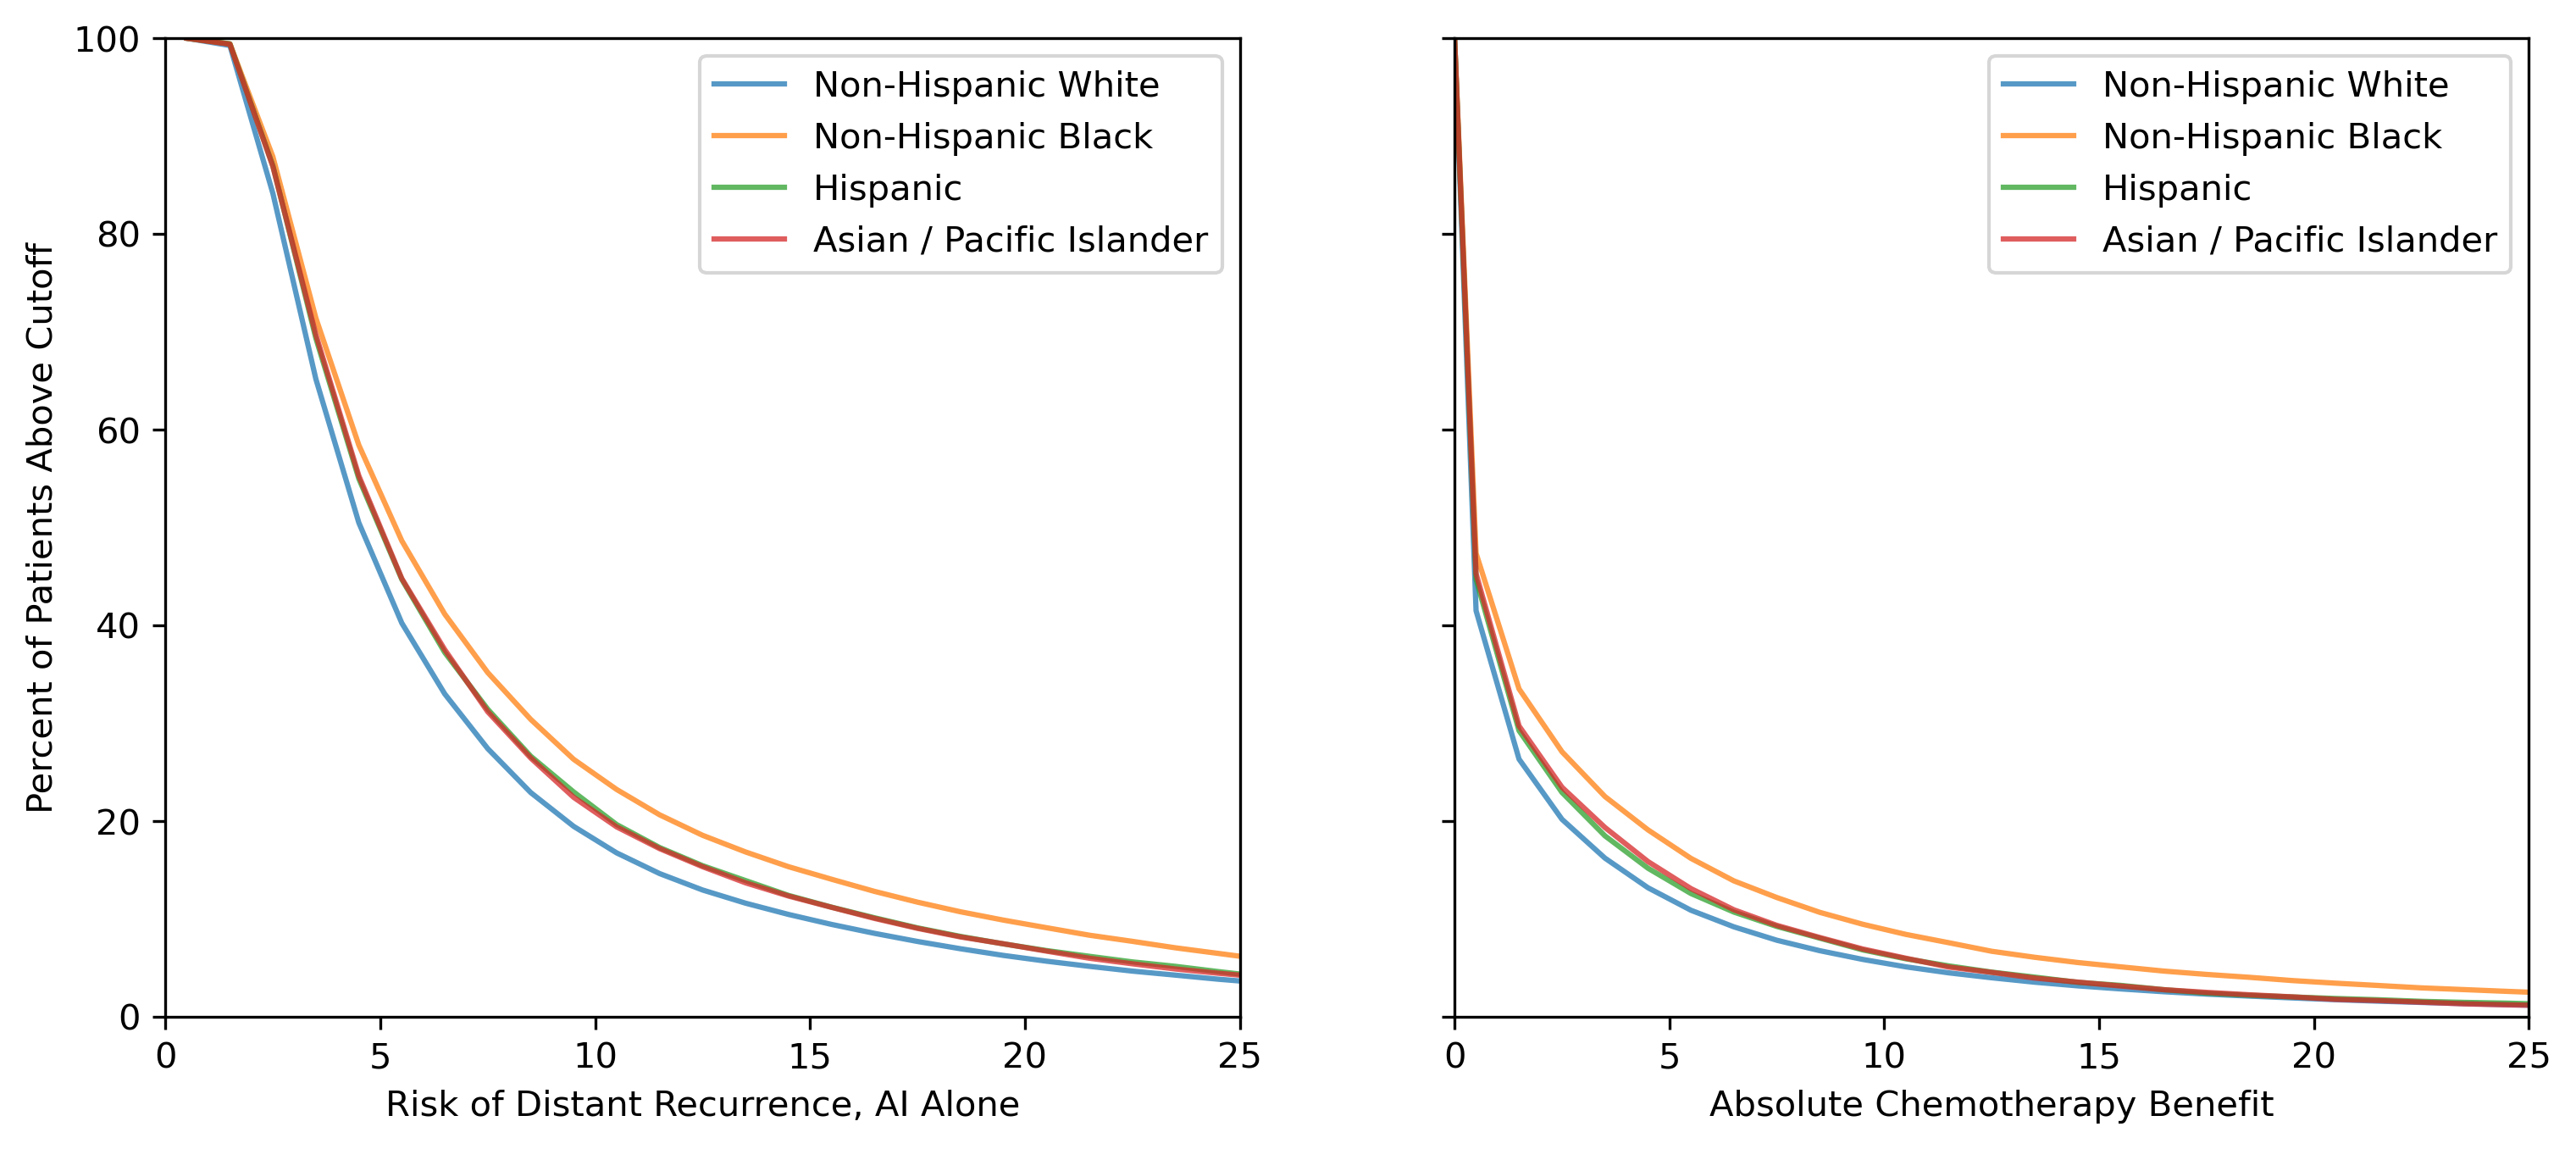

In [8]:
def graphHistogram_race(df, column = 'riskAI', title = "", smoothed = True, ax = None):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        column - parameter to plot
        title - title of variable to use
        smoothed - to graph a smoothed version of histogram
        ax - provide axis for plotting
        """
    for race, label in zip([0,1,2,5],['Non-Hispanic White','Non-Hispanic Black','Hispanic','Asian / Pacific Islander']):
        dfrace = df[df.race_parse == race]
        X, F = np.unique(np.sort(dfrace[column]), return_index=True)
        F = 100* F / float(F.max())
        if not smoothed:
            N = len(dfrace.index)
            X = np.sort(dfrace[column])
            F = np.array(range(N))/float(N)
        if ax:
            ax.plot(X-0.5, F, label=label, alpha = 0.75)
    if ax:
        ax.set_xlabel(title)
        if title == "Risk of Distant Recurrence, AI Alone":
            ax.set_ylabel("Percent of Patients Above Cutoff")
        ax.set_xlim([0,25])
        ax.set_ylim([0,100])
        ax.invert_yaxis()
        ax.set_yticklabels([100,80,60,40,20,0])
        ax.legend(loc = 'upper right')

    
def raceCharacteristics(df):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        """
    columns = ['age', 'grade', 'tumor_size', 'recurrence_score', 'riskAI', 'absBenefitAI']
    df['race_parse'] = df.race_parse.map({0:'Non-Hispanic White', 1:'Non-Hispanic Black', 2:'Hispanic', 3:'Other', 4:'Native American', 5:'Asian'})
    mytable = tableone(df, columns=columns, categorical=['grade'], groupby='race_parse', pval=True)
    print(mytable.tabulate(tablefmt="github"))
    mytable.to_excel('table two.xlsx')
    
fig, ax = plt.subplots(1, 2, sharey=True, dpi = 300, figsize=(12, 5))
df = prepareDataset(LN = 2)
raceCharacteristics(df.copy())
graphHistogram_race(df, title = "Risk of Distant Recurrence, AI Alone", ax = ax[0])
graphHistogram_race(df, 'absBenefitAI', "Absolute Chemotherapy Benefit", ax = ax[1])
fig.savefig("figure 2.png")
plt.show()

# Prognostic Value of RSClin Predictions

In [ ]:
df_concord = cph._predicted_partial_h
df = self._predicted_partial_hazards_
                     

def cphConcordance(df, columns):
    """Get concordance index for survival within dataframe for a CoxPH model using a subset of columns

    Parameters
    ----------
    df - dataset on which to get concordance index
    columns - columns to use to generate a CoxPH model
    """
    cph = CoxPHFitter(penalizer=0.4)
    cph.fit(df[columns + ['last_contact', 'alive']].dropna(), robust=True, duration_col='last_contact', event_col='alive')
    print("For CoxPH model including " + ", ".join(columns) + ": CI=" + str(round(cph.concordance_index_,6)))
    
def printConcordanceIndex(df):
#     Print concordance index for cox models with variables of interest    
    df=df.dropna(subset=['riskAI','recurrence_score','grade','tumor_size','age'])
    df['chemo*RSClin'] = df['chemo'] * df['absBenefitAI']
    df['riskAI'] = df['riskAI']
    df['chemo*RS'] = df['chemo'] * df['recurrence_score']
    cphConcordance(df[df.chemo == 0], ['riskAI'])
    cphConcordance(df[df.chemo == 0], ['recurrence_score'])
    cphConcordance(df[df.chemo == 0], ['grade'])
    cphConcordance(df[df.chemo == 0], ['tumor_size'])
    cphConcordance(df[df.chemo == 0], ['grade', 'tumor_size'])
    cphConcordance(df[df.chemo == 0], ['grade', 'tumor_size', 'recurrence_score'])
    cphConcordance(df[df.chemo == 0], ['riskAI', 'age'])
    cphConcordance(df[df.chemo == 0], ['recurrence_score', 'age'])
    cphConcordance(df[df.chemo == 0], ['grade', 'age'])
    cphConcordance(df[df.chemo == 0], ['tumor_size', 'age'])
    cphConcordance(df[df.chemo == 0], ['grade', 'tumor_size', 'age'])
    cphConcordance(df[df.chemo == 0], ['grade', 'tumor_size', 'recurrence_score', 'age'])

### Prepare chemo and no chemo high odx datasets:
df = prepareDataset(LN = 0)
printConcordanceIndex(df)

503


,Group,No Chemo (n),Chemo (n),Median Follow-Up (mo),8 Year Mortality HR,p,Chemo 8yr Survival (%),No Chemo 8yr Survival (%)
0,"High RS, high RSClin",7176,18889,64.39,0.68 (0.64-0.72),< 0.01,16.1 (15.8-16.4),25.1 (23.7-26.5)
1,"High RS, int RSClin",2594,2870,60.50,0.72 (0.6-0.85),< 0.01,6.2 (5.7-6.8),9.1 (7.6-10.9)
2,"Low RS, high RSClin",5036,2773,54.97,0.85 (0.77-0.94),< 0.01,14.2 (13.5-14.9),20.5 (18.8-22.5)
3,"Low RS, int RSClin",202043,14987,56.11,1.04 (1.01-1.07),0.02,8.9 (8.7-9.2),9.2 (nan-9.4)


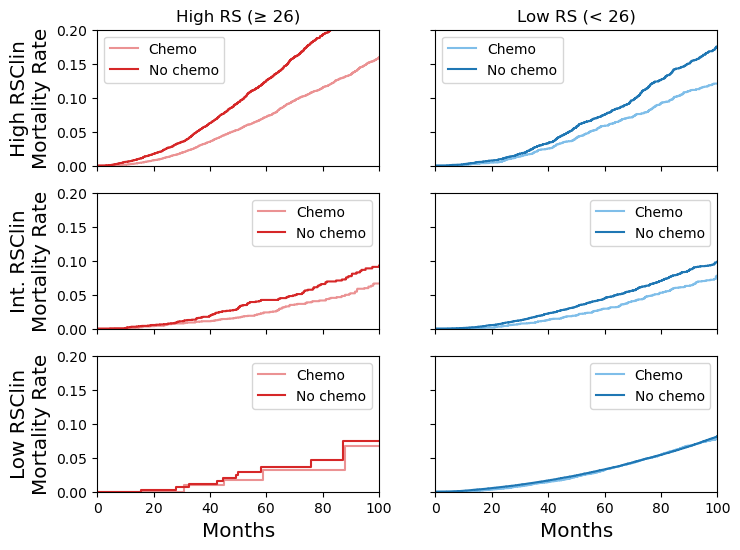

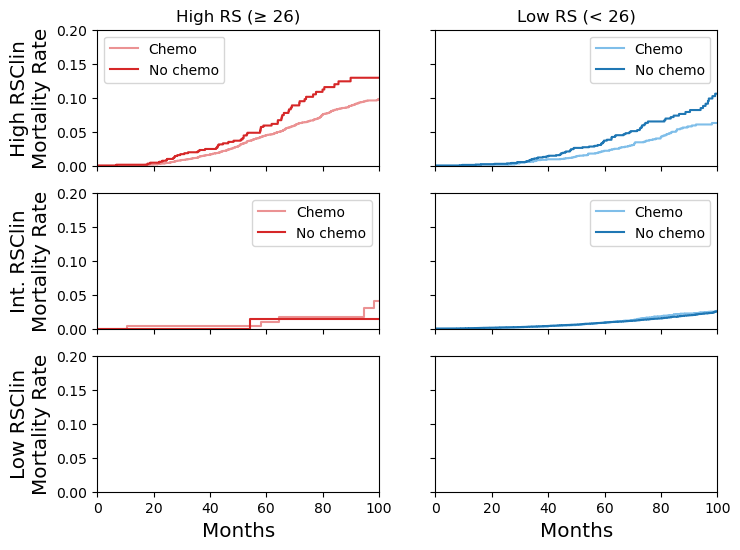

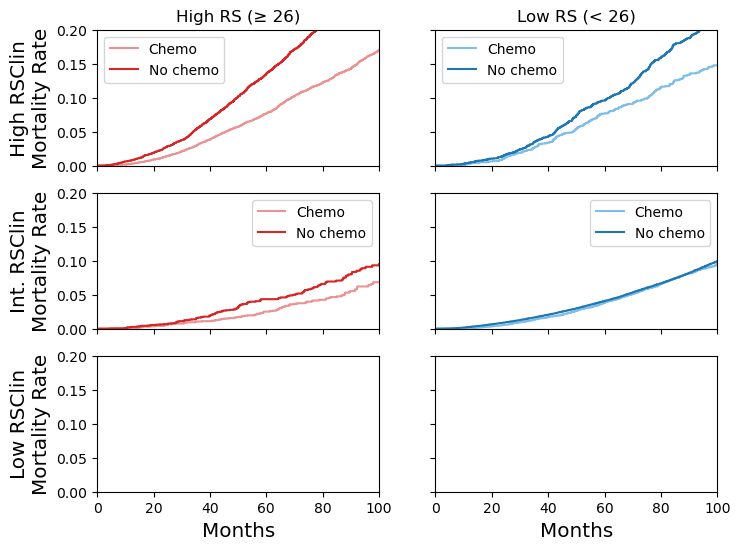

In [214]:
###Tasks:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def roundp(p, peq = False):
    """Return a formatted string for p values
    
    Parameters
    ----------
    p - p value float
    peq - True if need to include 'p' in the resulting string

    Returns
    -------
    Formatted p value string

    """
    if p < 0.01:
        if peq:
            return "p < 0.01"
        else:
            return "< 0.01"
    else:
        if peq:
            return "p = " + str(round(p,2))
        else:
            return str(round(p,2))
        

def discordant_table_3groups_new(df, addcolumns=None,propscore=None, robust=False, threshold_low=3, threshold_high=5, CI=False, axs = None, use_tam = False):
    "generates graph and table for high, intermediate and low RSClin and high/low ODX"
    
    if axs is None:
        fig, axs = plt.subplots(3,2, sharey = True, sharex = True, figsize=(8, 6))
        fig.add_gridspec(wspace=0,hspace=0)
    if use_tam:
        df['absBenefitAI'] = df['absBenefitTAM'].astype(float)
    columns_list = ['Group','No Chemo (n)', 'Chemo (n)','Median Follow-Up (mo)', '8 Year Mortality HR', '95% Lower Bound', '95% Upper Bound', 'z', 'p','Chemo 8yr Survival (%)', 'Chemo 8yr Survival Lower Bound (%)', 'Chemo 8yr Survival Upper Bound (%)','No Chemo 8yr Survival (%)', 'No Chemo 8yr Survival Lower Bound (%)', 'No Chemo 8yr Survival Upper Bound (%)']

    df_highodx_highRSClin = df[(df.recurrence_score >=26) & (df.absBenefitAI >= threshold_high)].dropna(subset=['last_contact', 'alive'])
    cph = CoxPHFitter()
    cph.fit(df_highodx_highRSClin[['chemo', 'last_contact', 'alive',propscore]+addcolumns].dropna(), robust = robust, weights_col=propscore, duration_col = 'last_contact', event_col = 'alive')
    
    highodx_highRSClin_HRs = ['High RS, high RSClin',len(df_highodx_highRSClin[df.chemo == 0].index), len(df_highodx_highRSClin[df.chemo == 1].index),df_highodx_highRSClin['last_contact'].median(),cph.hazard_ratios_['chemo'],math.exp(float(cph.confidence_intervals_.loc['chemo']['95% lower-bound'])),math.exp(float(cph.confidence_intervals_.loc['chemo']['95% upper-bound'])),cph.summary.z.tolist()[0],cph.summary.p.tolist()[0]]

    kmf = KaplanMeierFitter(label = "Chemo")
    chemodf = df_highodx_highRSClin[df_highodx_highRSClin.chemo==1]
    kmf.fit(chemodf['last_contact'], chemodf['alive'],weights=chemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[0][0], ci_show=CI, color=lighten_color('C3'))
    
    highodx_highRSClin_HRs.append(kmf.predict(12*8)*100)
    highodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    highodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)

    kmf = KaplanMeierFitter(label = "No chemo")
    nochemodf = df_highodx_highRSClin[df_highodx_highRSClin.chemo==0]
    kmf.fit(nochemodf['last_contact'], nochemodf['alive'],weights=nochemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[0][0], ci_show=CI, color='C3')
    
    highodx_highRSClin_HRs.append(kmf.predict(12*8)*100)
    highodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    highodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)
   
    #
    
    df_lowodx_highRSClin = df[(df.recurrence_score <26) & (df.absBenefitAI >= threshold_high)].dropna(subset=['last_contact', 'alive'])
    cph = CoxPHFitter()
    cph.fit(df_lowodx_highRSClin[['chemo', 'last_contact', 'alive',propscore]+addcolumns].dropna(), robust = robust, weights_col=propscore, duration_col = 'last_contact', event_col = 'alive')

    lowodx_highRSClin_HRs = ['Low RS, high RSClin',len(df_lowodx_highRSClin[df.chemo == 0].index), len(df_lowodx_highRSClin[df.chemo == 1].index),df_lowodx_highRSClin['last_contact'].median(), cph.hazard_ratios_['chemo'],math.exp(float(cph.confidence_intervals_.loc['chemo']['95% lower-bound'])),math.exp(float(cph.confidence_intervals_.loc['chemo']['95% upper-bound'])),cph.summary.z.tolist()[0],cph.summary.p.tolist()[0]]

    kmf = KaplanMeierFitter(label = "Chemo")
    chemodf = df_lowodx_highRSClin[df_lowodx_highRSClin.chemo==1]
    kmf.fit(chemodf['last_contact'], chemodf['alive'],weights=chemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[0][1], ci_show=CI, color=lighten_color('C0'))
    
    lowodx_highRSClin_HRs.append(kmf.predict(12*8)*100)
    lowodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    lowodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)

    kmf = KaplanMeierFitter(label = "No chemo")
    nochemodf = df_lowodx_highRSClin[df_lowodx_highRSClin.chemo==0]
    kmf.fit(nochemodf['last_contact'], nochemodf['alive'],weights=nochemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[0][1], ci_show=CI, color='C0')
    
    lowodx_highRSClin_HRs.append(kmf.predict(12*8)*100)
    lowodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    lowodx_highRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)
    
    #

    df_highodx_intRSClin = df[(df.recurrence_score >=26) & (df.absBenefitAI >=threshold_low) & (df.absBenefitAI <threshold_high)].dropna(subset=['last_contact', 'alive'])
    cph = CoxPHFitter()

    cph.fit(df_highodx_intRSClin[['chemo', 'last_contact', 'alive',propscore]+addcolumns].dropna(), robust = robust, weights_col=propscore, duration_col = 'last_contact', event_col = 'alive')

    highodx_intRSClin_HRs = ['High RS, int RSClin',len(df_highodx_intRSClin[df.chemo == 0].index), len(df_highodx_intRSClin[df.chemo == 1].index),df_highodx_intRSClin['last_contact'].median(), cph.hazard_ratios_['chemo'],math.exp(float(cph.confidence_intervals_.loc['chemo']['95% lower-bound'])),math.exp(float(cph.confidence_intervals_.loc['chemo']['95% upper-bound'])),cph.summary.z.tolist()[0],cph.summary.p.tolist()[0]]

    kmf = KaplanMeierFitter(label = "Chemo")
    chemodf = df_highodx_intRSClin[df_highodx_intRSClin.chemo==1]
    kmf.fit(chemodf['last_contact'], chemodf['alive'],weights=chemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[1][0], ci_show=CI, color=lighten_color('C3'))

    highodx_intRSClin_HRs.append(kmf.predict(12*8)*100)
    highodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    highodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)
        
    kmf = KaplanMeierFitter(label = "No chemo")
    nochemodf = df_highodx_intRSClin[df_highodx_intRSClin.chemo==0]
    kmf.fit(nochemodf['last_contact'], nochemodf['alive'],weights=nochemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[1][0], ci_show=CI, color='C3')

    highodx_intRSClin_HRs.append(kmf.predict(12*8)*100)
    highodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    highodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)
        

#     #
    
    df_lowodx_intRSClin = df[(df.recurrence_score <26) & (df.absBenefitAI >=threshold_low) & (df.absBenefitAI <threshold_high)].dropna(subset=['last_contact', 'alive'])
    cph = CoxPHFitter()
    cph.fit(df_lowodx_intRSClin[['chemo', 'last_contact', 'alive',propscore]+addcolumns].dropna(), robust = robust, weights_col=propscore, duration_col = 'last_contact', event_col = 'alive')
    
    lowodx_intRSClin_HRs = ['Low RS, int RSClin',len(df_lowodx_intRSClin[df.chemo == 0].index), len(df_lowodx_intRSClin[df.chemo == 1].index),df_lowodx_intRSClin['last_contact'].median(), cph.hazard_ratios_['chemo'],math.exp(float(cph.confidence_intervals_.loc['chemo']['95% lower-bound'])),math.exp(float(cph.confidence_intervals_.loc['chemo']['95% upper-bound'])),cph.summary.z.tolist()[0],cph.summary.p.tolist()[0]]

    kmf = KaplanMeierFitter(label = "Chemo")
    chemodf = df_lowodx_intRSClin[df_lowodx_intRSClin.chemo==1]
    kmf.fit(chemodf['last_contact'], chemodf['alive'],weights=chemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[1][1], ci_show=CI, color=lighten_color('C0'))
  
    lowodx_intRSClin_HRs.append(kmf.predict(12*8)*100)
    lowodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
    lowodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)

    kmf = KaplanMeierFitter(label = "No chemo")
    nochemodf = df_lowodx_intRSClin[df_lowodx_intRSClin.chemo==0]
    kmf.fit(nochemodf['last_contact'], nochemodf['alive'],weights=nochemodf[propscore])
    kmf.plot_cumulative_density(ax = axs[1][1], ci_show=CI, color='C0')

    lowodx_intRSClin_HRs.append(kmf.predict(12*8)*100)
    lowodx_intRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)    
    
    


    #
    if threshold_low > 0:
        df_highodx_lowRSClin = df[(df.recurrence_score >=26) & (df.absBenefitAI <threshold_low)].dropna(subset=['last_contact', 'alive'])
        if len(df_highodx_lowRSClin.index) > 50:
            print(len(df_highodx_lowRSClin.index))
            cph = CoxPHFitter()

            cph.fit(df_highodx_lowRSClin[['chemo', 'last_contact', 'alive',propscore]+addcolumns].dropna(), robust = robust, weights_col=propscore, duration_col = 'last_contact', event_col = 'alive')

            highodx_lowRSClin_HRs = ['High RS, low RSClin',len(df_highodx_lowRSClin[df.chemo == 0].index), len(df_highodx_lowRSClin[df.chemo == 1].index),df_highodx_lowRSClin['last_contact'].median(), cph.hazard_ratios_['chemo'],math.exp(float(cph.confidence_intervals_.loc['chemo']['95% lower-bound'])),math.exp(float(cph.confidence_intervals_.loc['chemo']['95% upper-bound'])),cph.summary.z.tolist()[0],cph.summary.p.tolist()[0]]

            kmf = KaplanMeierFitter(label = "Chemo")
            chemodf = df_highodx_lowRSClin[df_highodx_lowRSClin.chemo==1]
            kmf.fit(chemodf['last_contact'], chemodf['alive'],weights=chemodf[propscore])
            kmf.plot_cumulative_density(ax = axs[2][0], ci_show=CI, color=lighten_color('C3'))

            highodx_lowRSClin_HRs.append(kmf.predict(12*8)*100)
            highodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
            highodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)

            kmf = KaplanMeierFitter(label = "No chemo")
            nochemodf = df_highodx_lowRSClin[df_highodx_lowRSClin.chemo==0]
            kmf.fit(nochemodf['last_contact'], nochemodf['alive'],weights=nochemodf[propscore])
            kmf.plot_cumulative_density(ax = axs[2][0], ci_show=CI, color='C3')

            highodx_lowRSClin_HRs.append(kmf.predict(12*8)*100)
            highodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
            highodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)
        else:
            highodx_lowRSClin_HRs = ['High RS, low RSClin',len(df_highodx_lowRSClin[df.chemo == 0].index), len(df_highodx_lowRSClin[df.chemo == 1].index)]

        #

        df_lowodx_lowRSClin = df[(df.recurrence_score <26) & (df.absBenefitAI <threshold_low)].dropna(subset=['last_contact', 'alive'])
        cph = CoxPHFitter()
        cph.fit(df_lowodx_lowRSClin[['chemo', 'last_contact', 'alive',propscore]+addcolumns].dropna(), robust = robust, weights_col=propscore, duration_col = 'last_contact', event_col = 'alive')

        lowodx_lowRSClin_HRs = ['Low RS, low RSClin',len(df_lowodx_lowRSClin[df.chemo == 0].index), len(df_lowodx_lowRSClin[df.chemo == 1].index),df_lowodx_lowRSClin['last_contact'].median(), cph.hazard_ratios_['chemo'],math.exp(float(cph.confidence_intervals_.loc['chemo']['95% lower-bound'])),math.exp(float(cph.confidence_intervals_.loc['chemo']['95% upper-bound'])),cph.summary.z.tolist()[0],cph.summary.p.tolist()[0]]

        kmf = KaplanMeierFitter(label = "Chemo")
        chemodf = df_lowodx_lowRSClin[df_lowodx_lowRSClin.chemo==1]
        kmf.fit(chemodf['last_contact'], chemodf['alive'],weights=chemodf[propscore])
        kmf.plot_cumulative_density(ax = axs[2][1], ci_show=CI, color=lighten_color('C0'))

        lowodx_lowRSClin_HRs.append(kmf.predict(12*8)*100)
        lowodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
        lowodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)

        kmf = KaplanMeierFitter(label = "No chemo")
        nochemodf = df_lowodx_lowRSClin[df_lowodx_lowRSClin.chemo==0]
        kmf.fit(nochemodf['last_contact'], nochemodf['alive'],weights=nochemodf[propscore])
        kmf.plot_cumulative_density(ax = axs[2][1], ci_show=CI, color='C0')

        lowodx_lowRSClin_HRs.append(kmf.predict(12*8)*100)
        lowodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][0])*100)
        lowodx_lowRSClin_HRs.append(float(kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*8].iloc[0][1])*100)

    axs[0][0].set_ylabel('High RSClin\nMortality Rate', fontsize = 'x-large')
    axs[1][0].set_ylabel('Int. RSClin\nMortality Rate', fontsize = 'x-large')
    axs[2][0].set_ylabel('Low RSClin\nMortality Rate', fontsize = 'x-large')
    axs[2][0].set_xlabel('Months', fontsize = 'x-large')
    axs[2][1].set_xlabel('Months', fontsize = 'x-large')
    #ax1.set_xlabel('Months', fontsize = 'xlarge')
    #ax2.set_xlabel('Months', fontsize = 'xlarge')

    axs[0][0].title.set_text('High RS (≥ 26)')
    axs[0][1].title.set_text('Low RS (< 26)')
    #ax1.title.set_fontsize('x-large')
    #ax2.title.set_fontsize('x-large')

    axs[0][0].set_xlim([0, 100])
    axs[0][0].set_ylim([0, 0.2])
    #ax2.set_xlim([0, 100])
    #ax2.set_ylim([0, 0.2])
    #for i in [0,1,2]:
    #    for j in [0,1]:
    #        axs[i][j].legend(loc = 'upper left')
    #ax1.legend(fontsize='x-large')
    #ax2.legend(fontsize='x-large')


    #
    if threshold_low > 0:
        HR_data_lists = [highodx_highRSClin_HRs,lowodx_highRSClin_HRs,highodx_intRSClin_HRs,lowodx_intRSClin_HRs, highodx_lowRSClin_HRs,lowodx_lowRSClin_HRs]
    else:
        HR_data_lists = [highodx_highRSClin_HRs,highodx_intRSClin_HRs,lowodx_highRSClin_HRs, lowodx_intRSClin_HRs]
    HR_table_df = pd.DataFrame(HR_data_lists)
    HR_table_df.columns = columns_list
    HR_table_df = HR_table_df.round({'8 Year Mortality HR':2, '95% Lower Bound':2, '95% Upper Bound':2, 'z':2,'Chemo 8yr Survival (%)':2, 'Chemo 8yr Survival Lower Bound (%)':2, 'Chemo 8yr Survival Upper Bound (%)':2,'No Chemo 8yr Survival (%)':2, 'No Chemo 8yr Survival Lower Bound (%)':2, 'No Chemo 8yr Survival Upper Bound (%)':2})
    HR_table_df['8 Year Mortality HR'] = round(HR_table_df['8 Year Mortality HR'],2).astype(str) + ' (' + round(HR_table_df['95% Lower Bound'],2).astype(str) + '-' + round(HR_table_df['95% Upper Bound'],2).astype(str) + ')'
    HR_table_df['Chemo 8yr Survival (%)'] = round(100 - HR_table_df['Chemo 8yr Survival (%)'], 1).astype(str) + ' (' + round(100 - HR_table_df['Chemo 8yr Survival Upper Bound (%)'], 1).astype(str) + '-' + round(100 - HR_table_df['Chemo 8yr Survival Lower Bound (%)'], 1).astype(str) + ')'
    HR_table_df['No Chemo 8yr Survival (%)'] = round(100 - HR_table_df['No Chemo 8yr Survival (%)'], 1).astype(str) + ' (' + round(100 - HR_table_df['No Chemo 8yr Survival Upper Bound (%)'], 1).astype(str) + '-' + round(100 - HR_table_df['No Chemo 8yr Survival Lower Bound (%)'], 1).astype(str) + ')'
    HR_table_df['p'] = HR_table_df['p'].apply(roundp)
#   HR_table_df = HR_table_df.set_index('Group', inplace=True, drop=False)
    return HR_table_df[['Group','No Chemo (n)', 'Chemo (n)', 'Median Follow-Up (mo)','8 Year Mortality HR', 'p','Chemo 8yr Survival (%)','No Chemo 8yr Survival (%)']]



discordant_table_3groups_new(df, addcolumns=['age','cdcc'], propscore = 'score_ACRI',threshold_low=3, threshold_high=5)

### Now again, splitting patients above and below 50 years
discordant_table_3groups_new(df[df.age < 50], addcolumns=['age','cdcc'], propscore = 'score_ACRI',threshold_low=-1, threshold_high=5)
discordant_table_3groups_new(df[df.age > 50], addcolumns=['age','cdcc'], propscore = 'score_ACRI',threshold_low=-1, threshold_high=5)



In [110]:
### Descriptive statistics of patients in specific RSClin/ODX bins

df_highodx_highRSClin = df[(df.recurrence_score >=26) & (df.absBenefitAI >= 5)].dropna(subset=['last_contact', 'alive'])
df_highodx_highRSClin.describe()

,age,cdcc,histology,grade,tumor_size,regional_nodes_positive,receptors,recurrence_score,last_contact,alive,...,riskTAMUCL,riskAI,riskAILCL,riskAIUCL,absBenefitTAM,absBenefitTAMLCL,absBenefitTAMUCL,absBenefitAI,absBenefitAILCL,absBenefitAIUCL
count,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000,27314.0,26267.000000,27314.000000,27314.000000,27314.000000,...,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000,27314.000000
mean,59.011899,0.214579,0.298345,2.524273,20.030351,0.0,106.729356,35.000659,69.548782,0.096324,...,41.242000,22.993703,13.955298,35.675185,17.124368,2.710149,31.427949,14.726550,2.192465,27.180164
std,11.316768,0.534099,1.176351,0.554846,15.158427,0.0,7.814862,10.256335,31.411745,0.295041,...,20.050343,13.005454,7.694160,19.041819,12.082001,6.105398,18.915568,10.936322,5.202076,17.629710
min,18.000000,0.000000,0.000000,1.000000,1.000000,0.0,10.000000,26.000000,0.000000,0.000000,...,15.000000,7.000000,3.000000,12.000000,5.000000,-18.000000,11.000000,5.000000,-18.000000,9.000000
25%,51.000000,0.000000,0.000000,2.000000,13.000000,0.0,100.000000,28.000000,46.230000,0.000000,...,25.000000,13.000000,8.000000,21.000000,9.000000,-1.000000,17.000000,7.000000,-1.000000,14.000000
50%,60.000000,0.000000,0.000000,3.000000,18.000000,0.0,110.000000,31.000000,66.140000,0.000000,...,37.000000,20.000000,12.000000,31.000000,13.000000,1.000000,26.000000,11.000000,1.000000,22.000000
75%,67.000000,0.000000,0.000000,3.000000,25.000000,0.0,110.000000,38.000000,92.390000,0.000000,...,53.000000,29.000000,18.000000,45.000000,21.000000,4.000000,39.000000,18.000000,3.000000,34.000000
max,90.000000,3.000000,11.000000,3.000000,989.000000,0.0,110.000000,100.000000,146.400000,1.000000,...,99.000000,97.000000,63.000000,99.000000,93.000000,73.000000,99.000000,92.000000,68.000000,99.000000


Predicted Distant Recurrence Rate on AI, n, 8 Yr Mortality Rate (95% CI), 8 Yr Mortality Rate Adj (95% CI), HR (95% CI), p, Adjusted HR (95% CI), p
0 - 5,128011,6.4 (6.1 - 6.6),6.0 (5.9 - 6.2),1.00,--,1.00,--
5 - 10,67468,7.7 (7.4 - 8.0),7.3 (7.0 - 7.6),1.1 (1.05 - 1.15),< 0.01,1.1 (1.06 - 1.15),< 0.01
10 - 15,14507,12.1 (11.3 - 13.1),11.6 (10.8 - 12.4),1.75 (1.64 - 1.88),< 0.01,1.45 (1.36 - 1.55),< 0.01
15 - 20,5236,16.4 (14.7 - 18.2),15.7 (14.3 - 17.3),2.43 (2.21 - 2.67),< 0.01,1.87 (1.71 - 2.05),< 0.01
20 - 25,2158,22.0 (19.5 - 25.3),21.2 (19.0 - 24.2),3.35 (2.96 - 3.8),< 0.01,2.32 (2.06 - 2.61),< 0.01


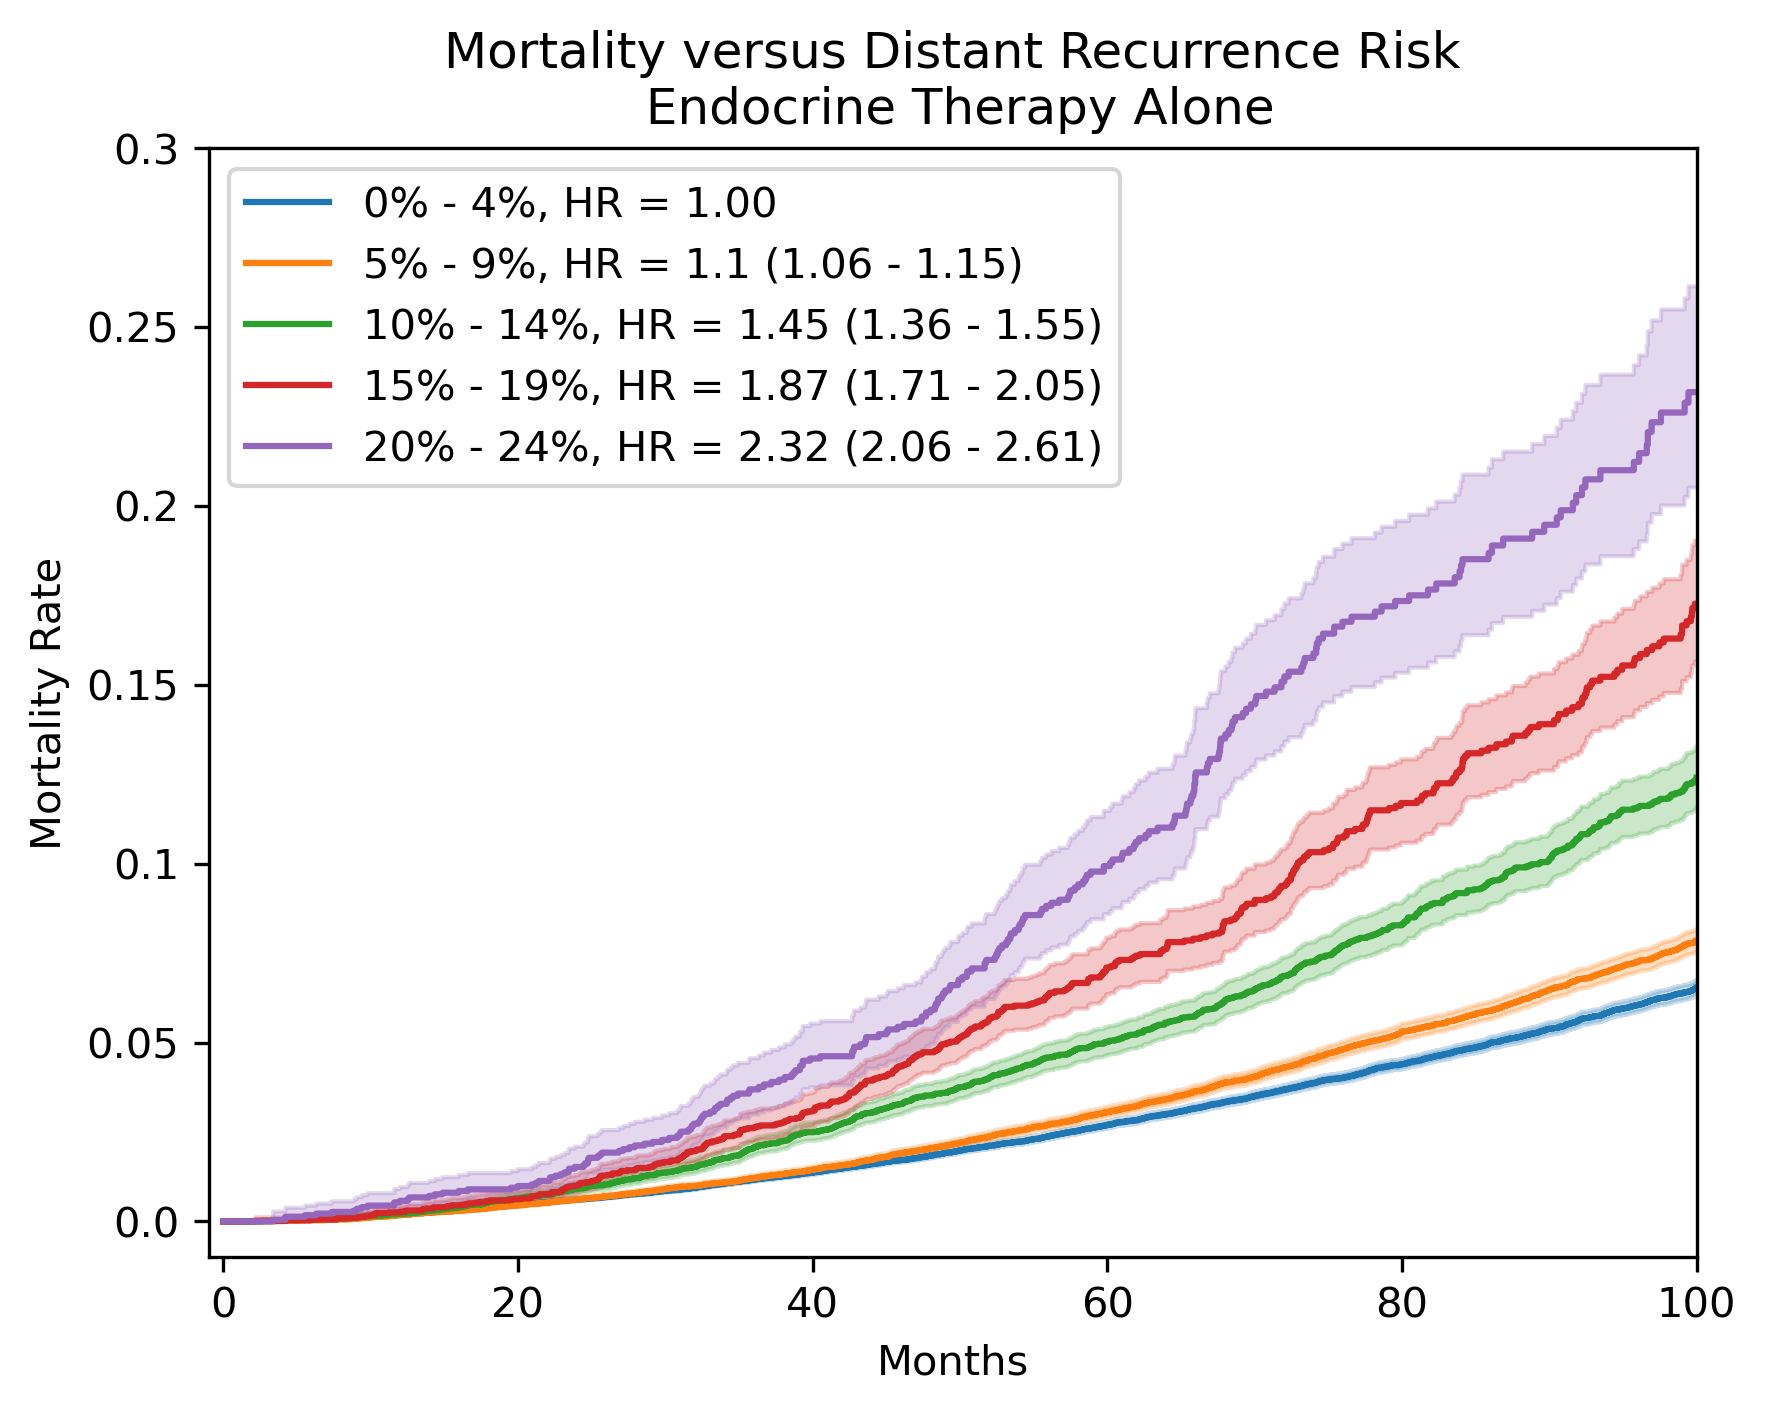

Group, No Chemo (n), Chemo (n), 8 Year Mortality, No Chemo (%), 8 Year Mortality, Chemo (%), HR, p, 8 Year Mortality, No Chemo (%), 8 Year Mortality, Chemo (%), HR, p
< 3%,195713,9378,7.1 (6.9 - 7.2),4.9 (4.4 - 5.5),0.66 (0.6 - 0.74),< 0.01,6.7 (5.8 - 6.4),6.1 (6.5 - 6.9),1.0 (0.95 - 1.04),0.87
3-5%,15226,9437,9.4 (8.6 - 10.2),5.4 (4.8 - 6.1),0.52 (0.46 - 0.59),< 0.01,8.9 (6.1 - 6.7),6.4 (8.3 - 9.6),0.67 (0.62 - 0.73),< 0.01
> 5%,8878,21535,20.5 (19.2 - 21.8),11.6 (11.0 - 12.2),0.52 (0.48 - 0.56),< 0.01,19.7 (12.9 - 13.4),13.1 (18.5 - 20.8),0.67 (0.63 - 0.71),< 0.01



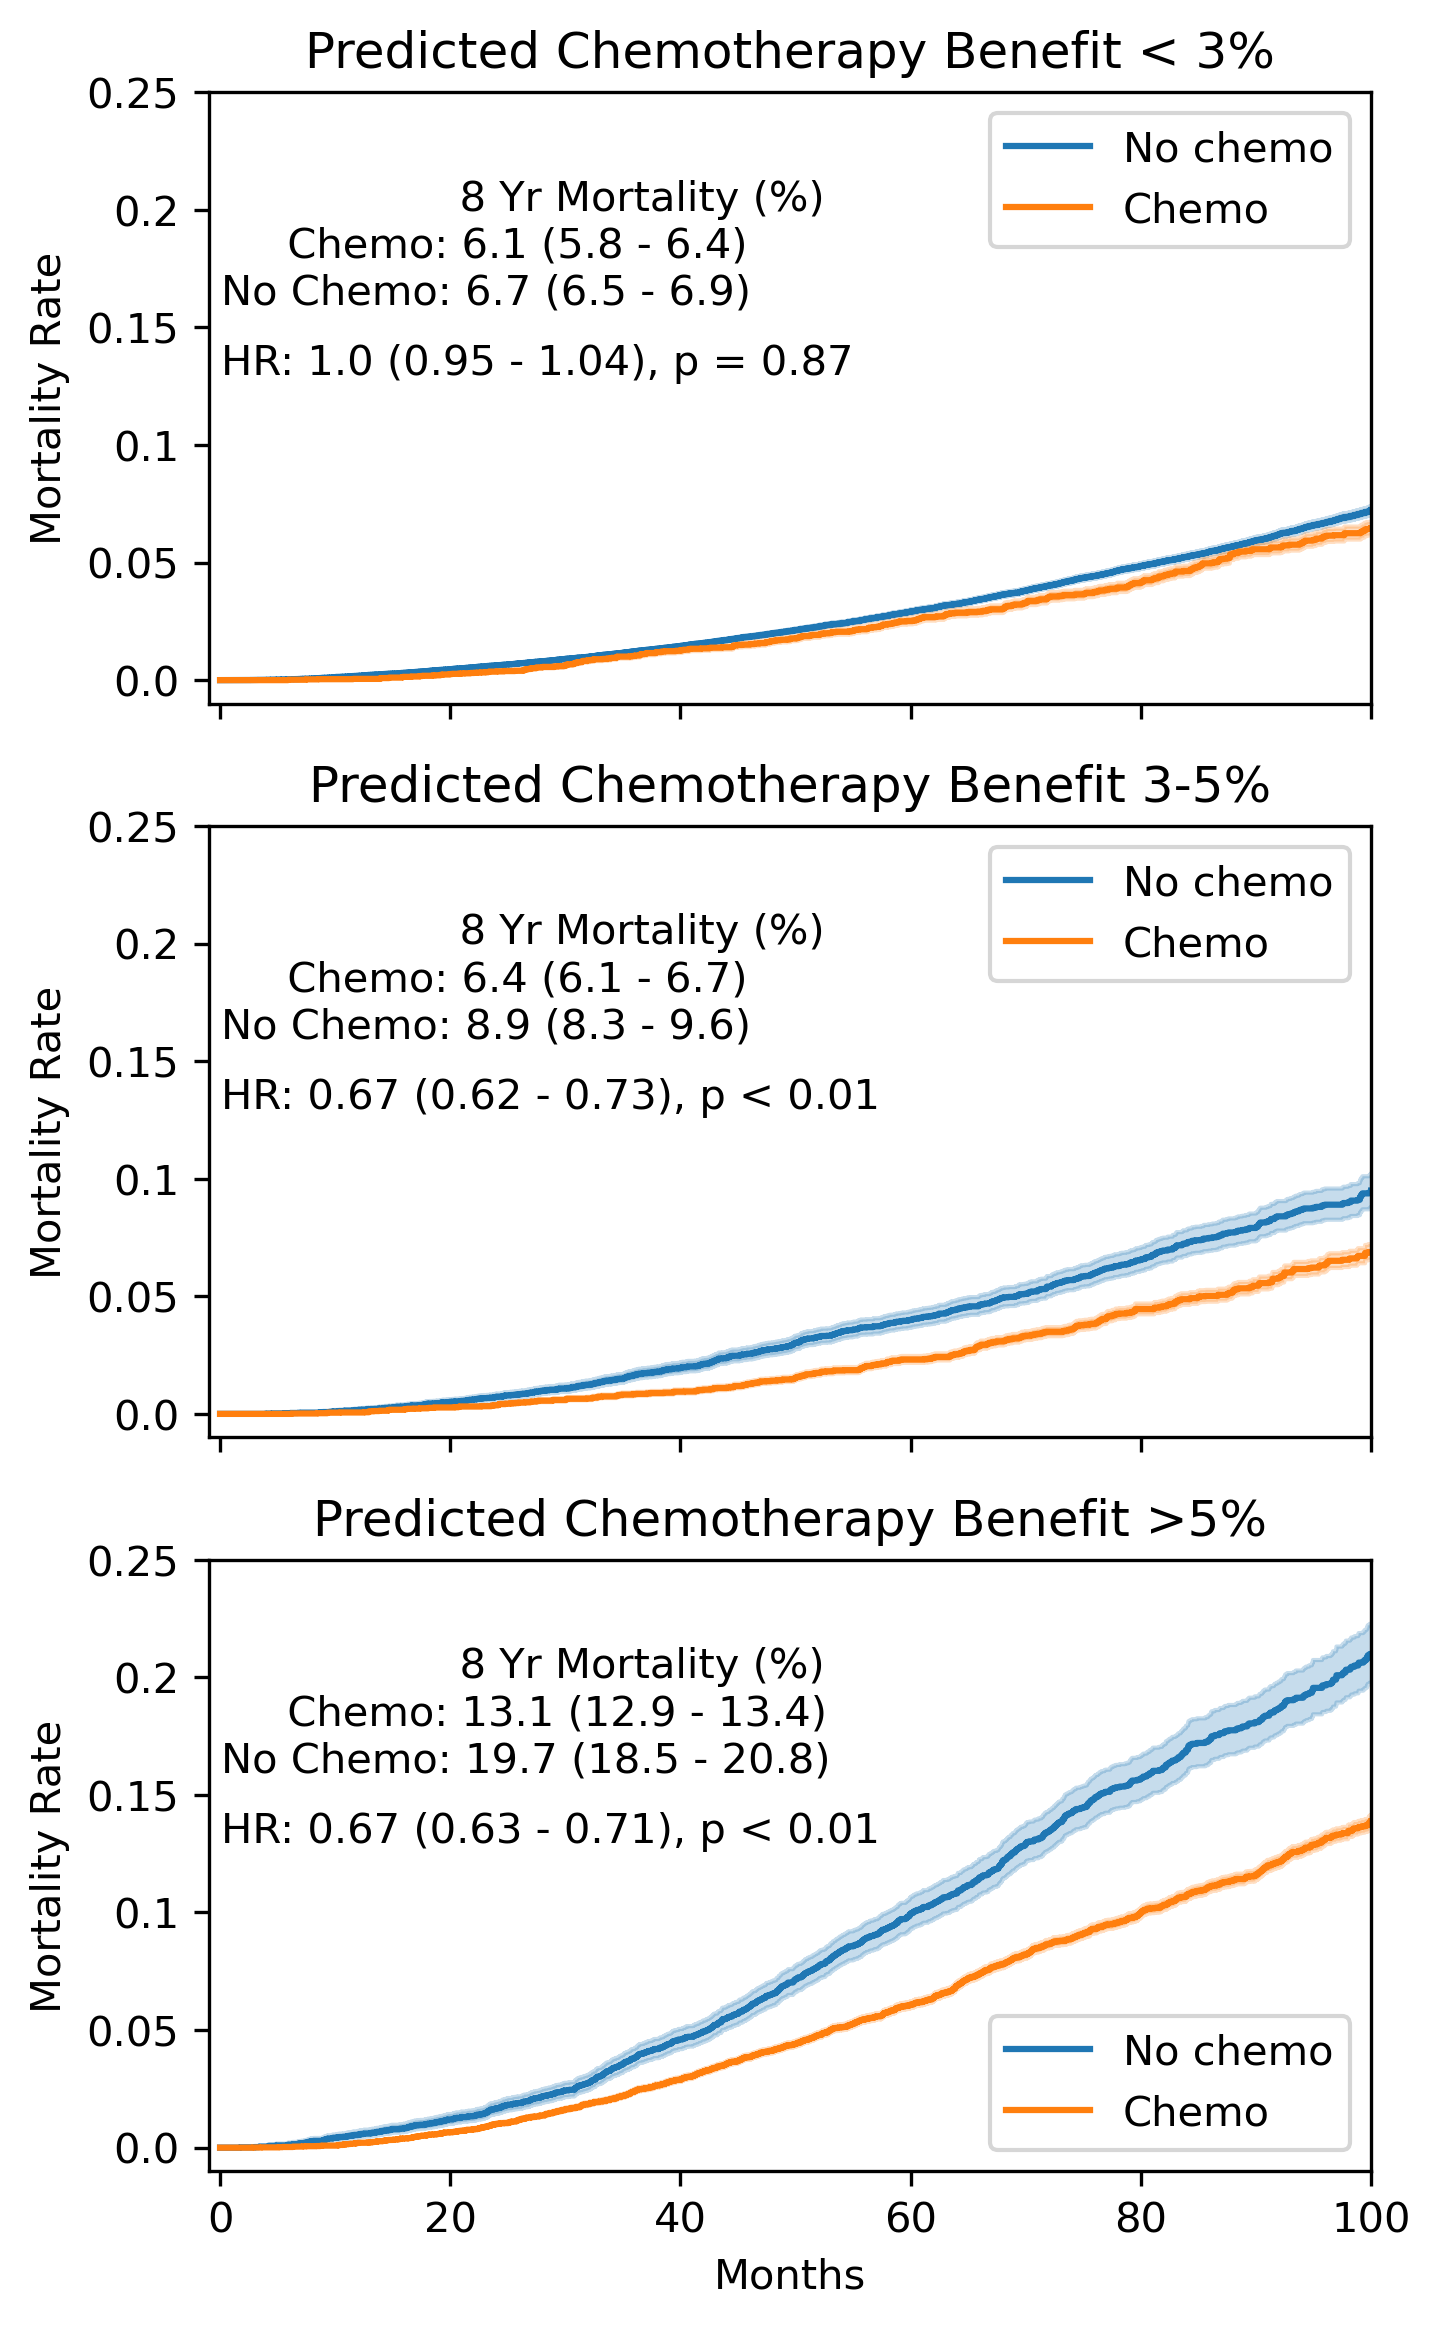

Group, n, 8 Yr Mortality Rate (95% CI), 8 Yr Mortality Rate Adj (95% CI)
High RSClin, Low / Intermediate Oncotype,3541,14.4 (12.5 - 16.5),13.7 (12.0 - 15.6),
High RS, Low / Intermediate Oncotype,3416,9.1 (7.7 - 10.8),8.9 (7.6 - 10.4),
Group, n, 8 Yr Mortality Rate (95% CI), 8 Yr Mortality Rate Adj (95% CI)
High RSClin, Low / Intermediate Oncotype,2940,7.9 (6.6 - 9.4),9.5 (8.8 - 10.2),
High RS, Low / Intermediate Oncotype,4674,6.2 (5.3 - 7.4),6.9 (6.5 - 7.4),


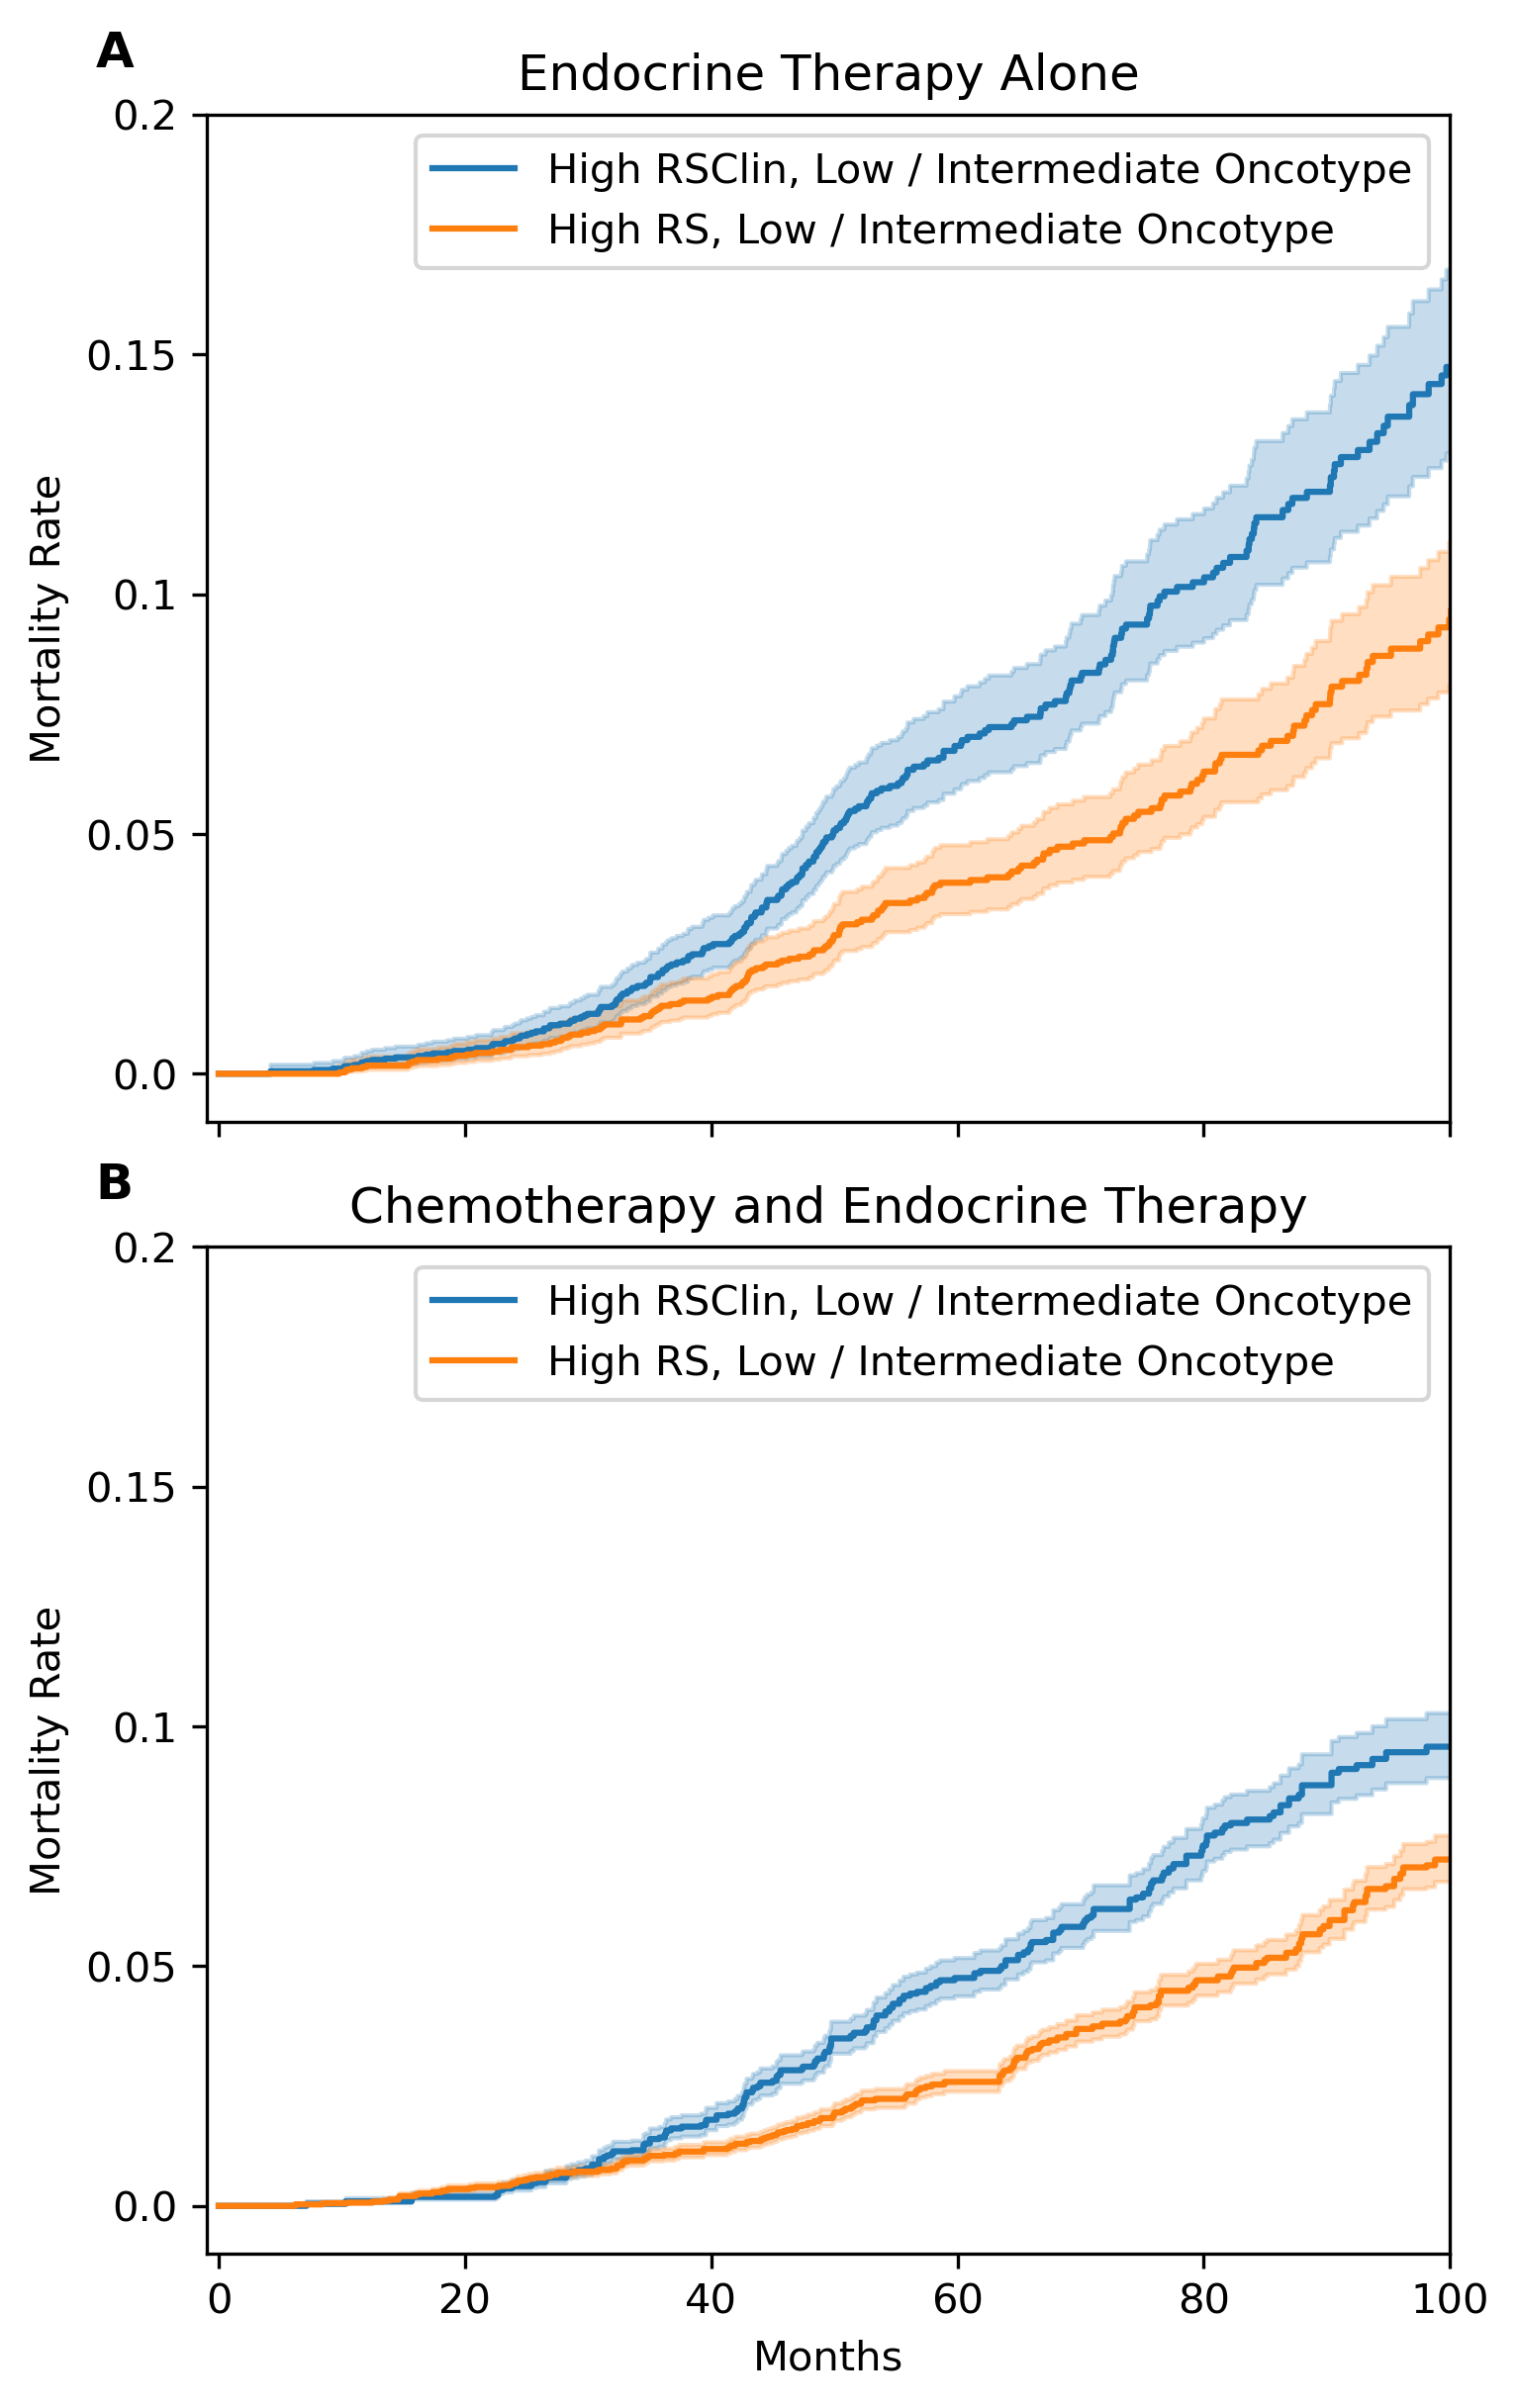

In [198]:
def graphSurvivalDataset(df, label = "", ax = None, pmatch = None):
    """Generate a Kaplan Meier Curve for OS within a dataframe,
    where 'alive' indicates event occurence and 'last_contact' indicates event time

    Parameters
    ----------
    df - dataset to graph
    label - label for dataset on legend
    ax - Matplotlib axis to graph on
    weighted - If True, will weight Kaplan Meier curve by column 'scores' in df

    Returns
    -------
    KaplanMeierFitter for dataset

    """

    kmf = KaplanMeierFitter(label=label)
    if pmatch:
        kmf.fit(df['last_contact'], df['alive'], weights = df[pmatch])
    else:
        kmf.fit(df['last_contact'], df['alive'])
    if ax:
        kmf.plot_survival_function(ax = ax)
    return kmf

def roundp(p, peq = False):
    """Return a formatted string for p values
    
    Parameters
    ----------
    p - p value float
    peq - True if need to include 'p' in the resulting string

    Returns
    -------
    Formatted p value string

    """
    if p < 0.01:
        if peq:
            return "p < 0.01"
        else:
            return "< 0.01"
    else:
        if peq:
            return "p = " + str(round(p,2))
        else:
            return str(round(p,2))

def graphSurvivalTwoGroups(dfs, labels, titleStr = "", pmatch = None, ax = None, mortality = True, robust = True):
    """ Compare survival between two groups
    Parameters
    ----------
    dfs - array of dataframes
    titleStr - title label for graph
    pmatch - to include column for IPTW
    ax - axis for plotting
    
    """
    ax.set_xlabel('Months')
    if mortality:
        ax.set_ylabel('Mortality Rate')
        ax.set_title(titleStr)
    else:
        ax.set_ylabel('Overall Survival')
        ax.set_title(titleStr)
    ax.set_ylim([0.7,1.01])
    ax.set_xlim([-1,100])
    if mortality:
        printTable = "Group, n, 8 Yr Mortality Rate (95% CI), 8 Yr Mortality Rate Adj (95% CI)"
    else:
        printTable = "Group, n, 8 Yr Survival Rate (95% CI), 8 Yr Survival Rate Adj (95% CI)"
    for df, l in zip(dfs, labels):
        graphSurvivalDataset(df, l, ax, pmatch = pmatch)
        printLine = l + ","
        printLine += str(len(df.index)) + ","
        kmf1 = graphSurvivalDataset(df, pmatch=None)
        siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
        if mortality:
            printLine += str(round(100 - 100*kmf1.predict(12*8),1)) + " (" + str(round(100 - 100*siga.values.tolist()[0][1],1)) + " - " +  str(round(100 - 100*siga.values.tolist()[0][0],1))  + "),"
        else:
            printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0],1)) + " - " +  str(round(100*siga.values.tolist()[0][1],1))  + "),"
        kmf1 = graphSurvivalDataset(df, pmatch=pmatch)
        siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
        if mortality:
            printLine += str(round(100 - 100*kmf1.predict(12*8),1)) + " (" + str(round(100 - 100*siga.values.tolist()[0][1],1)) + " - " +  str(round(100 - 100*siga.values.tolist()[0][0],1))  + "),"
        else:
            printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0],1)) + " - " +  str(round(100*siga.values.tolist()[0][1],1))  + "),"
        printTable += "\n" + printLine
    print(printTable)
        
def graphSurvivalPercentiles(df, var, q, titleStr = "", pmatch = None, ax = None, addColumns = [], mortality = True, robust = True):
    """Graph percentiles for variable within df

    Parameters
    ----------
    df - dataset to graph on
    var - variable within dataset to graph quartiles
    q - percentiles for variable
    titleStr - title label for graph
    pmatch - to include column for IPTW
    ax - axis for plotting
    """
    numPerc = len(q)
    if not ax:
        fig, ax = plt.subplots(1,1)
    quartileList = []
    for z in range(2,numPerc + 1):
        df['quartile' + str(z)] = 0
        quartileList += ['quartile' + str(z)]
    for z in range(1, numPerc+1):
        lower_quantile, upper_quantile = q[z-1]
        if z >= 2:
            df.loc[(df[var] >= lower_quantile) & (df[var] < upper_quantile), 'quartile' + str(z)] = 1
    cph = CoxPHFitter()
    cph.fit(df[quartileList + ['last_contact', 'alive', pmatch] + addColumns], robust=robust, duration_col='last_contact', event_col='alive', weights_col = pmatch)
    cph_unadj = CoxPHFitter()
    cph_unadj.fit(df[quartileList + ['last_contact', 'alive']], robust=robust, duration_col='last_contact', event_col='alive')
    for z in range(1, numPerc+1):
        lower_quantile, upper_quantile = q[z-1]
        if z == 1:
            graphSurvivalDataset(df.loc[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], str(int(lower_quantile)) + "% - " + str(int(upper_quantile - 1)) + "%, HR = 1.00", ax, pmatch = pmatch)
        else:
            cis = cph.confidence_intervals_[cph.confidence_intervals_.index == 'quartile' + str(z)].values.tolist()[0]
            graphSurvivalDataset(df.loc[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], str(int(lower_quantile)) + "% - " + str(int(upper_quantile - 1)) + "%, HR = " + str(round(cph.hazard_ratios_['quartile' + str(z)],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + ")", ax, pmatch = pmatch)
            
    ax.set_xlabel('Months')
    if mortality:
        ax.set_ylabel('Mortality Rate')
        ax.set_title('Mortality versus Distant Recurrence Risk\n Endocrine Therapy Alone' + titleStr)
    else:
        ax.set_ylabel('Overall Survival')
        ax.set_title('Survival versus Distant Recurrence Risk\n Endocrine Therapy Alone' + titleStr)
    ax.set_ylim([0.7,1.01])
    ax.set_xlim([-1,100])
    if mortality:
        printTable = "Predicted Distant Recurrence Rate on AI, n, 8 Yr Mortality Rate (95% CI), 8 Yr Mortality Rate Adj (95% CI), HR (95% CI), p, Adjusted HR (95% CI), p"
    else:
        printTable = "Predicted Distant Recurrence Rate on AI, n, 8 Yr Survival Rate (95% CI), 8 Yr Survival Rate Adj (95% CI), HR (95% CI), p, Adjusted HR (95% CI), p"
    for z in range(1, numPerc + 1):
        lower_quantile, upper_quantile = q[z-1]
        printLine = str(lower_quantile) + " - " + str(upper_quantile) + ","
        printLine += str(len(df[(df[var] >= lower_quantile) & (df[var] < upper_quantile)].index)) + ","
        kmf1 = graphSurvivalDataset(df[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], pmatch=None)
        siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
        if mortality:
            printLine += str(round(100 - 100*kmf1.predict(12*8),1)) + " (" + str(round(100 - 100*siga.values.tolist()[0][1],1)) + " - " +  str(round(100 - 100*siga.values.tolist()[0][0],1))  + "),"
        else:
            printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0],1)) + " - " +  str(round(100*siga.values.tolist()[0][1],1))  + "),"
        kmf1 = graphSurvivalDataset(df[(df[var] >= lower_quantile) & (df[var] < upper_quantile)], pmatch=pmatch)
        siga = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
        if mortality:
            printLine += str(round(100 - 100*kmf1.predict(12*8),1)) + " (" + str(round(100 - 100*siga.values.tolist()[0][1],1)) + " - " +  str(round(100 - 100*siga.values.tolist()[0][0],1))  + "),"
        else:
            printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0],1)) + " - " +  str(round(100*siga.values.tolist()[0][1],1))  + "),"
        if z == 1:
            printLine += "1.00,--,1.00,--"
        else:
            quartStr = "quartile" + str(z)
            cis = cph_unadj.confidence_intervals_[cph_unadj.confidence_intervals_.index == quartStr].values.tolist()[0]
            printLine += str(round(cph_unadj.hazard_ratios_[quartStr],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + ")," + roundp(cph_unadj.summary.p[quartStr]) + ","
            cis = cph.confidence_intervals_[cph.confidence_intervals_.index == quartStr].values.tolist()[0]
            printLine += str(round(cph.hazard_ratios_[quartStr],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + ")," + roundp(cph.summary.p[quartStr])
        printTable += "\n" + printLine
    print(printTable)
    
def getQuantiles(df, var, divs = [0, 0.25, 0.5, 0.75]):
    """Get quantiles for variable within df

    Parameters
    ----------
    df - dataset on which to get quartiles
    var - variable within dataset on which to get quartiles

    Returns
    -------
    q - a list where each element is the upper/lower bound for a quartile
    """
    q = []
    for i, iub, z in zip(divs, divs[1:] + [1], range(1, len(divs) + 1)):
        q += [df[var].quantile([i, iub])]
    return q

def graphSurvivalChemo(ax, df, pmatch = None, addColumns = [], mortality = True, robust = True, leg = 'upper right'):
    """Generate Kaplan Meier curves for survival/mortality in subgroups who received / didn't receive chemo

    Parameters
    ----------
    ax - Matplotlib axis to graph on
    df - dataset on which to graph
    pmatch - provide name of IPTW score column if performing IPTW
    mortality - True if plotting mortality, False to plot OS
    robust - robust confidence intervals for weighted CPH models (takes more time)
    """

    kmf1 = graphSurvivalDataset(df[df.chemo == 0], 'No chemo', ax, pmatch=pmatch)
    kmf2 = graphSurvivalDataset(df[df.chemo == 1], 'Chemo', ax, pmatch=pmatch)
    cph = CoxPHFitter()
    cph.fit(df[['chemo', 'last_contact', 'alive', pmatch] + addColumns], robust=robust, duration_col='last_contact', event_col='alive', weights_col=pmatch)


   
    results = survival_difference_at_fixed_point_in_time_test(8*12, kmf1, kmf2)
    p = results.p_value
    diffv = kmf2.predict(12*8) - kmf1.predict(12*8)
    
    sigb = kmf1.confidence_interval_survival_function_[kmf1.confidence_interval_survival_function_.index >= 12*8]
    siga = kmf2.confidence_interval_survival_function_[kmf2.confidence_interval_survival_function_.index >= 12*8]
    chemoCI = siga.values.tolist()[0]
    if mortality:
        ctext = "     Chemo: " + str(round(100 - 100*kmf2.predict(12*8),1)) + " (" + str(round(100 - 100*chemoCI[1], 1)) + " - " + str(round(100 - 100*chemoCI[0], 1)) + ")"
    else:
        ctext = "     Chemo: " + str(round(100*kmf2.predict(12*8),1)) + " (" + str(round(100*chemoCI[0], 1)) + " - " + str(round(100*chemoCI[1], 1)) + ")"
    chemoCI = sigb.values.tolist()[0]
    if mortality:
        etext = "No Chemo: " + str(round(100 - 100*kmf1.predict(12*8),1)) + " (" + str(round(100 - 100*chemoCI[1], 1)) + " - " + str(round(100 - 100*chemoCI[0], 1)) + ")"
    else:
        etext = "No Chemo: " + str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*chemoCI[0], 1)) + " - " + str(round(100*chemoCI[1], 1)) + ")"
    diffst = "           Diff: " + str(round(100*diffv, 1)) + ", p = " + roundp(p)

    cis = cph.confidence_intervals_[cph.confidence_intervals_.index == 'chemo'].values.tolist()[0]
    hrs = "HR: " + str(round(cph.hazard_ratios_['chemo'],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + "), " + roundp(cph.summary.p['chemo'], True)

    ax.set_ylim([0.75,1.01])
    ax.set_xlim([-1,100])
    ax.legend(loc=leg)
    if mortality:
        ax.set_ylabel('Mortality Rate')
        ax.annotate("                  8 Yr Mortality (%)", (0.1,0.8))
        ax.annotate(ctext, (0.1, 0.82))
        ax.annotate(etext, (0.1, 0.84))
        ax.annotate(hrs, (0.1, 0.87))
    else:
        ax.set_ylabel('OS')
        ax.annotate("                   8 Yr OS (%)", (0.1,0.9))
        ax.annotate(ctext, (0.1, 0.88))
        ax.annotate(etext, (0.1, 0.86))
        ax.annotate(hrs, (0.1, 0.84))

    ax.set_xlabel('Months')



    printLine = str(len(df[df.chemo == 0])) + "," + str(len(df[df.chemo == 1])) + ","
    kmfu1 = graphSurvivalDataset(df[df.chemo == 0])
    kmfu2 = graphSurvivalDataset(df[df.chemo == 1])
    sigau = kmfu1.confidence_interval_survival_function_[kmfu1.confidence_interval_survival_function_.index >= 12*8]
    sigbu = kmfu2.confidence_interval_survival_function_[kmfu2.confidence_interval_survival_function_.index >= 12*8]  
    if mortality:
        printLine += str(round(100 - 100*kmfu1.predict(12*8),1)) + " (" + str(round(100 - 100*sigau.values.tolist()[0][1], 1)) + " - " + str(round(100 - 100*sigau.values.tolist()[0][0], 1)) + "),"                 
        printLine += str(round(100 - 100*kmfu2.predict(12*8),1)) + " (" + str(round(100 - 100*sigbu.values.tolist()[0][1], 1)) + " - " + str(round(100 - 100*sigbu.values.tolist()[0][0], 1)) + "),"                 
    else:
        printLine += str(round(100*kmfu1.predict(12*8),1)) + " (" + str(round(100*sigau.values.tolist()[0][0], 1)) + " - " + str(round(100*sigau.values.tolist()[0][1], 1)) + "),"                 
        printLine += str(round(100*kmfu2.predict(12*8),1)) + " (" + str(round(100*sigbu.values.tolist()[0][0], 1)) + " - " + str(round(100*sigbu.values.tolist()[0][1], 1)) + "),"                 
    cphu = CoxPHFitter()
    cphu.fit(df[['chemo', 'last_contact', 'alive']], robust=robust, duration_col='last_contact', event_col='alive')
    cisu = cphu.confidence_intervals_[cphu.confidence_intervals_.index == 'chemo'].values.tolist()[0]
    printLine += str(round(cphu.hazard_ratios_['chemo'],2)) + " (" + str(round(math.exp(cisu[0]),2)) + " - " + str(round(math.exp(cisu[1]),2)) + "),"+ roundp(cphu.summary.p['chemo']) +","
    if mortality:
        printLine += str(round(100 - 100*kmf1.predict(12*8),1)) + " (" + str(round(100 - 100*siga.values.tolist()[0][1], 1)) + " - " + str(round(100 - 100*siga.values.tolist()[0][0], 1)) + "),"                 
        printLine += str(round(100 - 100*kmf2.predict(12*8),1)) + " (" + str(round(100 - 100*sigb.values.tolist()[0][1], 1)) + " - " + str(round(100 - 100*sigb.values.tolist()[0][0], 1)) + "),"                     
    else:
        printLine += str(round(100*kmf1.predict(12*8),1)) + " (" + str(round(100*siga.values.tolist()[0][0], 1)) + " - " + str(round(100*siga.values.tolist()[0][1], 1)) + "),"                 
        printLine += str(round(100*kmf2.predict(12*8),1)) + " (" + str(round(100*sigb.values.tolist()[0][0], 1)) + " - " + str(round(100*sigb.values.tolist()[0][1], 1)) + "),"                 
    printLine += str(round(cph.hazard_ratios_['chemo'],2)) + " (" + str(round(math.exp(cis[0]),2)) + " - " + str(round(math.exp(cis[1]),2)) + "),"+ roundp(cph.summary.p['chemo'])
    return printLine + "\n"
    
def graphEndo(df, pmatch= None, addColumns = [], robust = True):
    fig, ax = plt.subplots(dpi = 300)
    graphSurvivalPercentiles(df[df.chemo == 0], 'riskAI', [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)], pmatch = pmatch, ax = ax, addColumns = addColumns, mortality = True, robust = robust)
    plt.gca().invert_yaxis()
    ax.set_yticklabels([0.30,0.25, 0.20, 0.15, 0.10, 0.05, 0.0])
    fig.savefig("supplemental figure 2.png")
    plt.show()
    
def graphChemo(df, pmatch= None, addColumns = [], robust = True):
    fig = plt.figure(dpi = 300, figsize=(5,9))
    gs = fig.add_gridspec(3, 1)
    
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0], sharex = ax0)
    ax2 = fig.add_subplot(gs[2, 0], sharex = ax0)
    
    printTable = "Group, No Chemo (n), Chemo (n), 8 Year Mortality, No Chemo (%), 8 Year Mortality, Chemo (%), HR, p, 8 Year Mortality, No Chemo (%), 8 Year Mortality, Chemo (%), HR, p\n"
    printTable += "< 3%," + graphSurvivalChemo(ax0, df[(df.absBenefitAI > 0) & (df.absBenefitAI <3)], pmatch, addColumns = addColumns, mortality = True, robust = robust)
    ax0.set_title('Predicted Chemotherapy Benefit < 3%')
    printTable += "3-5%," + graphSurvivalChemo(ax1, df[(df.absBenefitAI >= 3) & (df.absBenefitAI <= 5)], pmatch, addColumns = addColumns, mortality = True, robust = robust)
    ax1.set_title('Predicted Chemotherapy Benefit 3-5%')
    printTable += "> 5%," + graphSurvivalChemo(ax2, df[(df.absBenefitAI > 5) & (df.absBenefitAI <= 1000)], pmatch, addColumns = addColumns, mortality = True, robust = robust, leg = 'lower right')
    ax2.set_title('Predicted Chemotherapy Benefit >5%')
    ax0.invert_yaxis()
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    print(printTable)
    
    ax0.set_yticklabels([0.25, 0.20, 0.15, 0.10, 0.05, 0.0])
    ax1.set_yticklabels([0.25, 0.20, 0.15, 0.10, 0.05, 0.0])
    ax2.set_yticklabels([0.25, 0.20, 0.15, 0.10, 0.05, 0.0])
    fig.savefig("figure 3 new.png")
    plt.show()
    
def graphEndoChemo(df, pmatch= None, addColumns = []):
    #Graphs Figure for endo and chemo with overall survival
    fig = plt.figure(constrained_layout=True, figsize=(5,12), dpi = 300)
    gs = fig.add_gridspec(4, 1, width_ratios = [1], height_ratios = [1,0.75,0.75,0.75])
    axendo = fig.add_subplot(gs[0, 0])
    graphSurvivalPercentiles(df[df.chemo == 0], 'riskAI', [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)], pmatch = pmatch, ax = axendo, addColumns = addColumns, mortality = False, robust = robust)
    ax0 = fig.add_subplot(gs[1, 0], sharex = axendo)
    ax1 = fig.add_subplot(gs[2, 0], sharex = axendo)
    ax2 = fig.add_subplot(gs[3, 0], sharex = axendo)
    axendo.annotate("A", (-10, 1.02), annotation_clip = False, fontsize=12, weight='bold')
    ax0.annotate("B", (-10, 1.02), annotation_clip  = False, fontsize=12, weight='bold')
    printTable = "Group, No Chemo (n), Chemo (n), 8 Year OS, No Chemo (%), 8 Year OS, Chemo (%), HR, p, 8 Year OS, No Chemo (%), 8 Year OS, Chemo (%), HR, p\n"
    printTable += "< 3%," + graphSurvivalChemo(ax0, df[(df.absBenefitAI > 0) & (df.absBenefitAI <3)], pmatch, mortality = False, addColumns = addColumns, robust = robust)
    ax0.set_title('Predicted Chemotherapy Benefit < 3%')
    printTable += "3-5%," + graphSurvivalChemo(ax1, df[(df.absBenefitAI >= 3) & (df.absBenefitAI <= 5)], pmatch, mortality = False, addColumns = addColumns, robust = robust)
    ax1.set_title('Predicted Chemotherapy Benefit 3-5%')
    printTable += "> 5%," + graphSurvivalChemo(ax2, df[(df.absBenefitAI > 5) & (df.absBenefitAI <= 1000)], pmatch, mortality = False,  addColumns = addColumns, robust = robust)
    ax2.set_title('Predicted Chemotherapy Benefit >5%')
    fig.savefig("figure 3.png")
    print(printTable)
    plt.show()

def graphEndoChemoSubgroups(df, pmatch = None):
    fig = plt.figure(constrained_layout=True, figsize=(5,8), dpi = 300)
    gs = fig.add_gridspec(2, 1, width_ratios = [1], height_ratios = [1, 1])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0], sharex = ax0)
    chemo_vals = [0]
    dfs = [df[(df.recurrence_score < 26) & (df.absBenefitAI > 5) & (df.chemo.isin(chemo_vals))], df[(df.recurrence_score >= 26) & (df.absBenefitAI <= 5) & (df.chemo.isin(chemo_vals))]]
    graphSurvivalTwoGroups(dfs, ["High RSClin, Low / Intermediate Oncotype", "High RS, Low / Intermediate Oncotype"], titleStr = "Endocrine Therapy Alone", ax = ax0, pmatch = pmatch, robust=True)
    chemo_vals = [1]
    dfs = [df[(df.recurrence_score < 26) & (df.absBenefitAI > 5) & (df.chemo.isin(chemo_vals))], df[(df.recurrence_score >= 26) & (df.absBenefitAI <= 5) & (df.chemo.isin(chemo_vals))]]
    graphSurvivalTwoGroups(dfs, ["High RSClin, Low / Intermediate Oncotype", "High RS, Low / Intermediate Oncotype"], titleStr = "Chemotherapy and Endocrine Therapy", ax = ax1, pmatch = pmatch, robust=True)
    ax0.set_ylim([0.8,1.01])
    ax1.set_ylim([0.8,1.01])
    ax0.set_yticks([0.8, 0.85, 0.90, 0.95, 1.0])
    ax1.set_yticks([0.8, 0.85, 0.90, 0.95, 1.0])
    ax0.set_yticklabels([0.20, 0.15, 0.10, 0.05, 0.0])
    ax1.set_yticklabels([0.20, 0.15, 0.10, 0.05, 0.0])
    ax0.invert_yaxis()
    ax1.invert_yaxis()
    ax0.set_xlabel("Months")
    ax1.set_xlabel("Months")
    ax0.annotate("A", (-10, 0.79), annotation_clip = False, fontsize=12, weight='bold')
    ax1.annotate("B", (-10, 0.79), annotation_clip  = False, fontsize=12, weight='bold')
    fig.savefig("sup fig 3.png")
    plt.show()

df = prepareDataset(LN=0, ncdbfile = 'NCDB2020.csv')

df = df.dropna(subset = ['chemo', 'age', 'cdcc', 'score_ACRI', 'last_contact', 'alive'])
graphEndo(df, pmatch = 'score_ACRI', addColumns = ['age', 'cdcc'], robust = False)
graphChemo(df, pmatch = 'score_ACRI', addColumns = ['age', 'cdcc'], robust = False)
graphEndoChemoSubgroups(df, pmatch = 'score_ACRI')


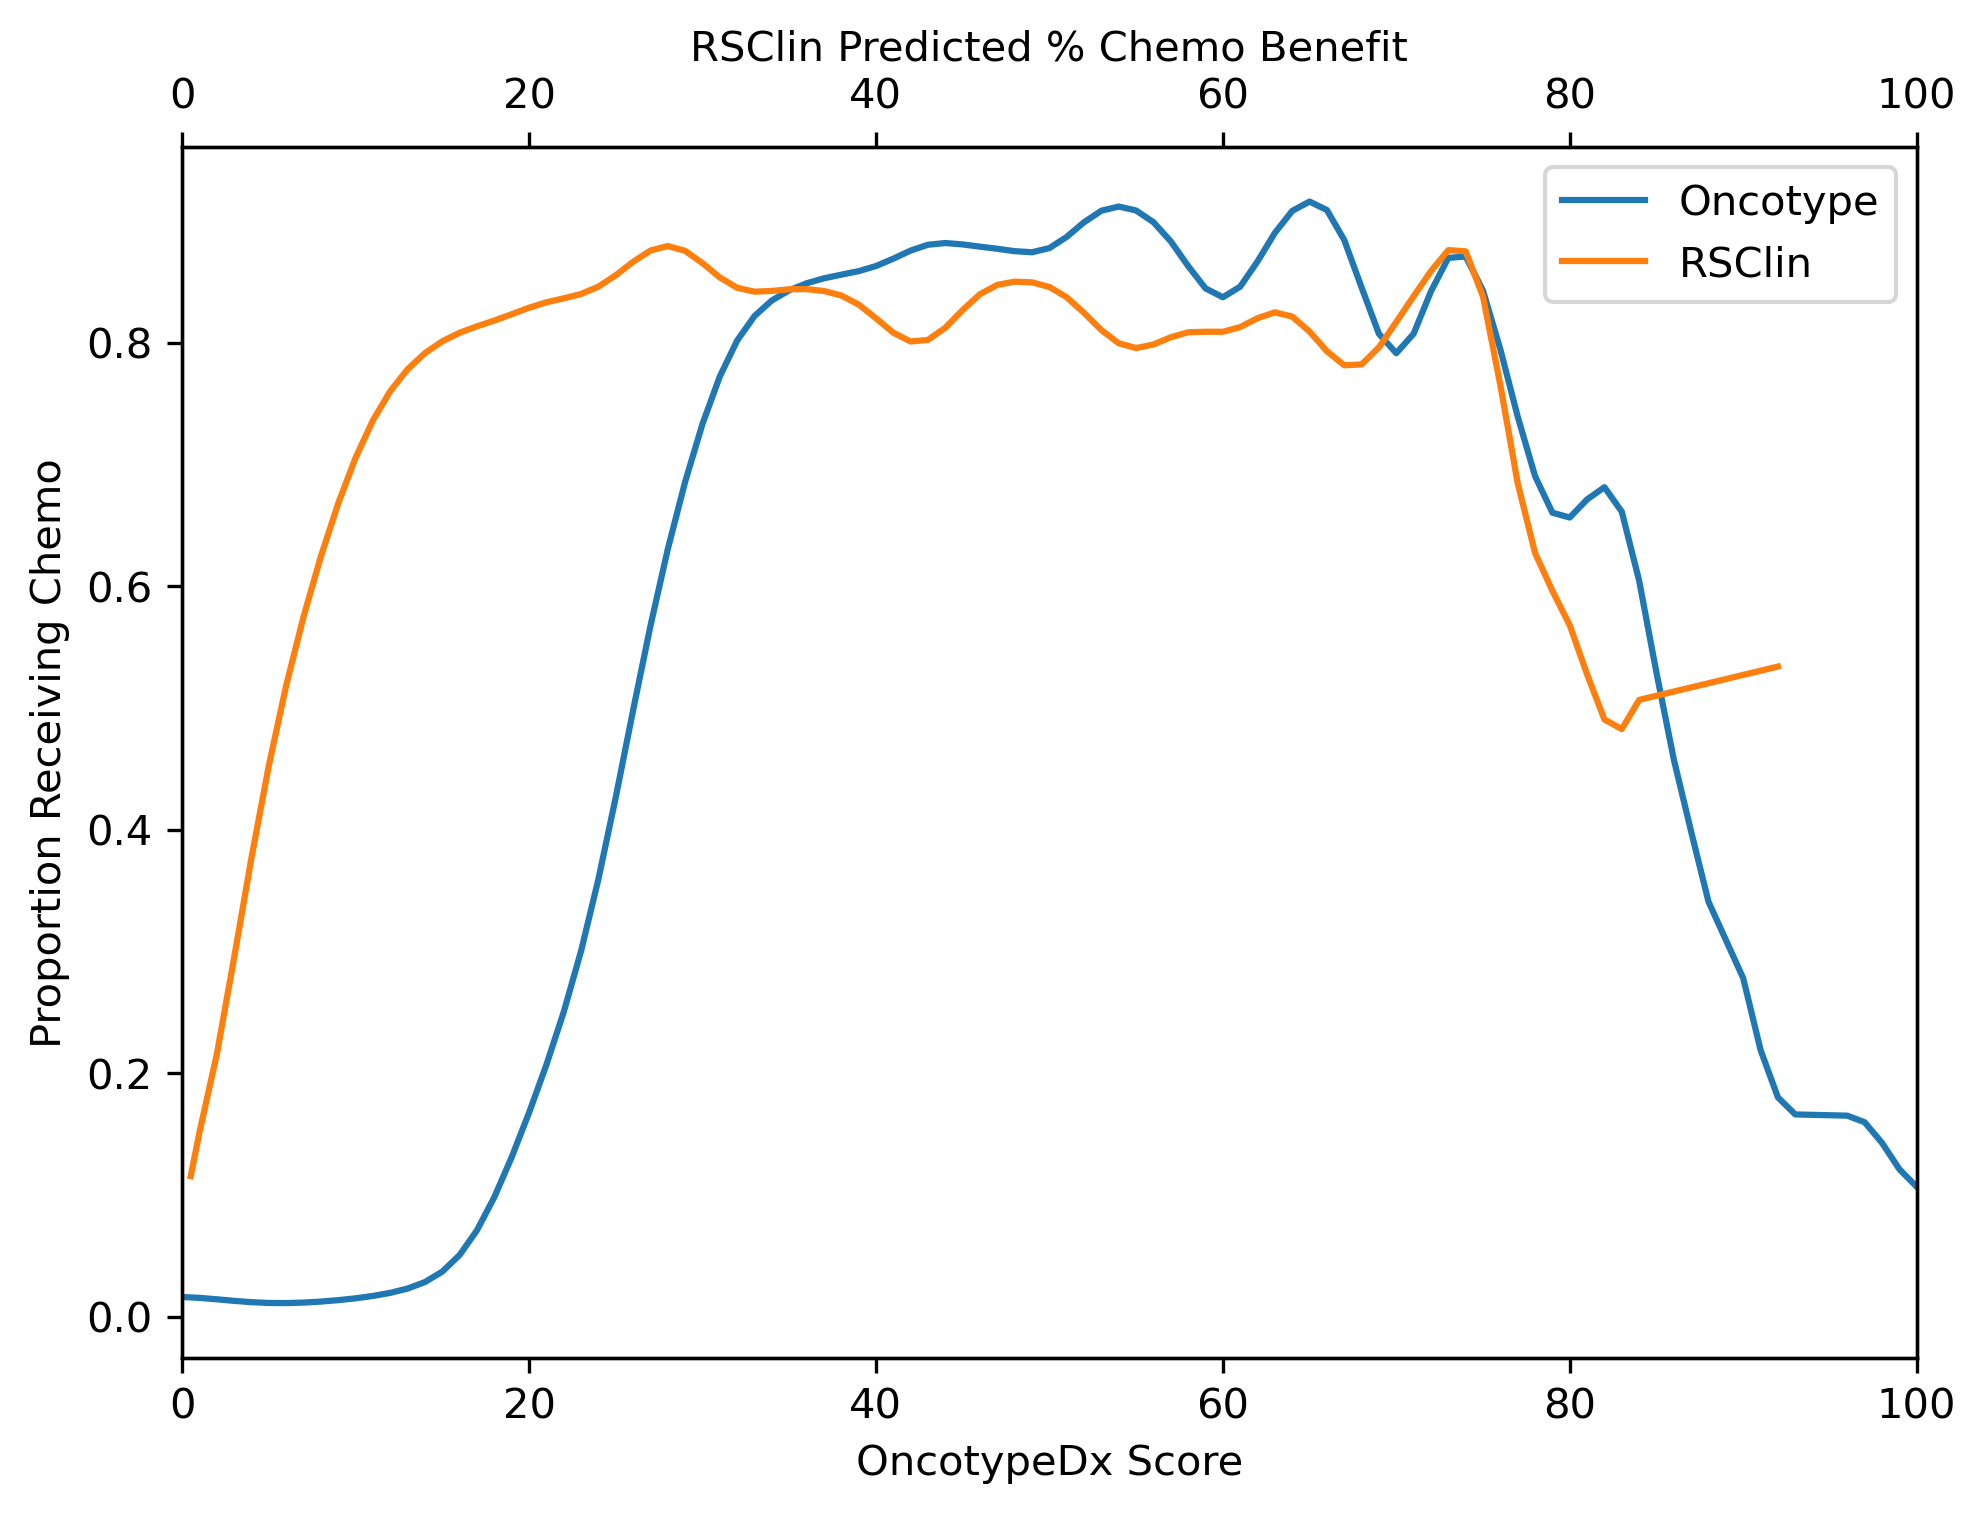

In [11]:
##Description of low / intermediate / high risk groups of Oncotype and RSClin
#df = prepareDataset(LN=0)
from scipy.ndimage.filters import gaussian_filter1d
fig, ax1 = plt.subplots(dpi = 300)
list_oncotype = df['recurrence_score'].value_counts().sort_index()
list_chemo = df.loc[df.chemo == 1, 'recurrence_score'].value_counts().sort_index()
#print((list_chemo/list_oncotype).to_string())
#print([0 if math.isnan(x) else x for x in list_chemo/list_oncotype])
#print([x for x in list_oncotype.index])
#ax1.plot(list_oncotype.index,[0 if math.isnan(x) else x for x in list_chemo/list_oncotype])
lns1 = ax1.plot(list_oncotype.index, gaussian_filter1d([0 if math.isnan(x) else x for x in list_chemo/list_oncotype], sigma=2), label = 'Oncotype')
#ax1.plot(list_oncotype.index, make_interp_spline([x for x in list_oncotype.index], [0 if math.isnan(x) else x for x in list_chemo/list_oncotype], k = 5)(list_oncotype.index), label = 'Oncotype')
ax2 = ax1.twiny()

list_rsclin = df['absBenefitAI'].value_counts().sort_index()
list_chemo = df.loc[df.chemo == 1, 'absBenefitAI'].value_counts().sort_index()
#ax2.plot(list_rsclin.index, [0 if math.isnan(x) else x for x in list_chemo/list_rsclin], label = 'RSClin')
lns2 = ax2.plot(list_rsclin.index, gaussian_filter1d([0 if math.isnan(x) else x for x in list_chemo/list_rsclin], sigma=2), label = 'RSClin', color = 'C1')
fig.tight_layout()

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_xlabel("OncotypeDx Score")
ax2.set_xlabel("RSClin Predicted % Chemo Benefit")
ax1.set_ylabel("Proportion Receiving Chemo")
ax1.set_xlim(0, 100)
ax2.set_xlim(0, 100)
fig.savefig("Supplemental Figure.png",bbox_inches="tight")
plt.show()

# Restricted Cubic Spline Regression

Knots [0.5, 1, 2]
2.0
Knots [0.5, 1, 2]
0.5


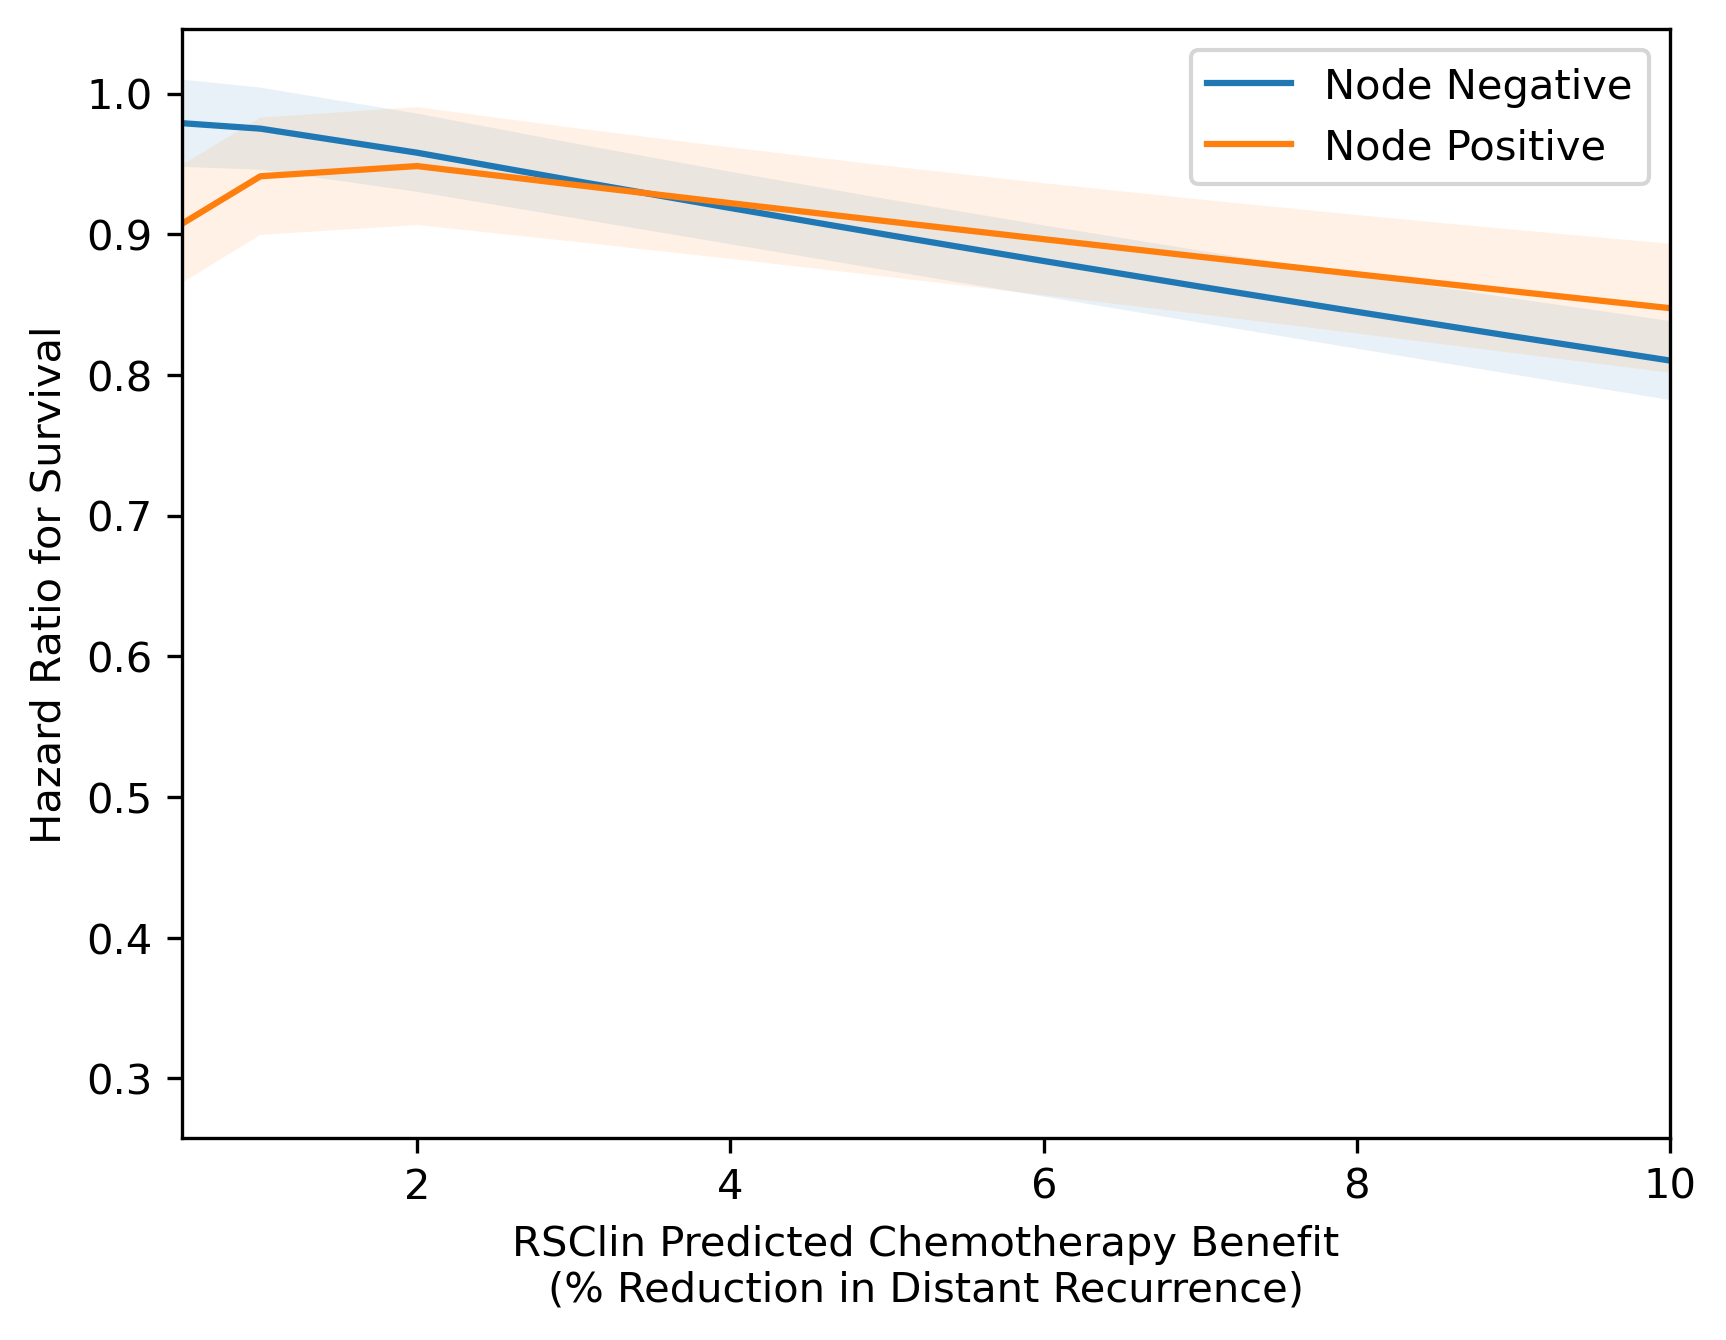

In [22]:
def rcs(x,knots,stub,norm=True,data=None):
    """Generate Kaplan Meier curves for survival in subgroups who received / didn't receive chemo

    Parameters
    ----------
    x - column from dataframe to generate spline
    knots - knots to use for spline
    stub - string to use as base for names of columns in spline
    norm  - to normalize by the square of the spacing between first and last knots
    data - if dataframe provided, will update with rows for knots
    """
    denom = knots[-1] - knots[-2]
    spline_li = []
    tot_knots = len(knots) - 2
    if norm:
        norm_val = (knots[-1] - knots[0])**2
    else:
        norm_val = 1
    for i in range(tot_knots):
        n1 = (knots[-1] - knots[i])/denom
        n2 = (knots[-2] - knots[i])/denom
        p1 = ((x - knots[i]).clip(0)**3)
        p2 = ((x - knots[-2]).clip(0)**3)*n1
        p3 = ((x - knots[-1]).clip(0)**3)*n2
        res = (p1 - p2 + p3)/norm_val
        spline_li.append(res)
    labels = [stub + str(i+1) for i in range(tot_knots)]
    if data is not None:
        for var,lab in zip(spline_li,labels):
            data[lab] = var
    else:
        res_df = pd.concat(spline_li,axis=1)
        res_df.columns = labels
        return res_df

knot_dict = {3: [0.1, 0.5, 0.9],
             4: [0.05, 0.35, 0.65, 0.95],
             5: [0.05, 0.275, 0.5, 0.725, 0.95],
             6: [0.05, 0.23, 0.41, 0.59, 0.77, 0.95],
             7: [0.025, 0.1833, 0.3417, 0.5, 0.6538, 0.8167, 0.975]}

def sug_knots(x,n):
    #Suggests n knots for data x
    if n < 3:
        print('Error, need n greater than 2')
        return -1
    elif n > 7:
        print('Error, need n less than 8')
        return -1
    else:
        loc_quants = knot_dict[n]
    for n in range(len(loc_quants)-1):
        l = list(x.quantile(loc_quants))
        while l[n] == l[n+1]:
            loc_quants[n+1] += 0.01
            l = list(x.quantile(loc_quants))
    return list(x.quantile(loc_quants))


def graphSpline3(df, column, ax, label, lb = 0, ub = 40, knots = 3, knotlist = None, covariates = []):
    """Graphs Cox Model with inputs RCS(column)*chemo, RCS(column), and chemo
    
    Parameters
    ----------
    df - dataframe to use for cox model
    column - column to use for spline generation
    ax - axis for graphing
    label - label for graph
    lb - lower bound for values in dataframe to include
    ub - upper bound for values in dataframe to include
    knots - number of knots to use
    knotlist - can provide a list of knots to use
    covariates - covariates to include in spline model
    """
    
    df = df[df[column] > lb]
    df = df[df[column] < ub]
    df = df.sort_values(column)
    if not knotlist:
        knotlist = sug_knots(df[column], knots)
    knots = len(knotlist)
    rcs(df[column], knotlist, 'rcs', data=df)
    df['rcs0'] = df[column]
    df['rcsc0'] = df[column] * df['chemo']
    colsvar = ['rcs0']
    colsvarchemo = ['rcsc0']
    for s in range(knots - 2):
        colsvar += ['rcs' + str(s+1)]
        colsvarchemo += ['rcsc' + str(s+1)]
        df['rcsc' + str(s+1)] = df['rcs' + str(s+1)] * df['chemo']
    print("Knots " + str(knotlist))
    cph = CoxPHFitter(penalizer = 0.001)
    #cph.fit(df[colsvarchemo + ['chemo'] + colsvar + ['last_contact', 'alive'] + covariates],
    #        duration_col='last_contact', event_col='alive', step_size=0.001)
    cph.fit(df[colsvarchemo + ['chemo'] + colsvar + ['last_contact', 'alive', 'score_ACRI'] + covariates],
            duration_col='last_contact', event_col='alive', weights_col = 'score_ACRI', robust = True)
    cis = cph.confidence_intervals_.values.tolist()
    hrs = cph.params_.values.tolist()
    ses = cph.standard_errors_.values.tolist()
    cl = []
    cu = []
    se = []
    b = []
    for s in range(knots):
        cl += [cis[s][0]]
        cu += [cis[s][1]]
        se += [ses[s]]
        b += [hrs[s]]
    cutoff = "NA"
    df['ones'] = 1
    colsvar += ['ones']
    b = np.array(b)
    se = np.array(se)

    covarM = np.array(cph.variance_matrix_.iloc[0:knots,0:knots].values.tolist())
    #delta method
    #covarp = np.sqrt((df[colsvar].values.dot(covarM) * (df[colsvar].values)).sum(axis = 1))
    d = np.exp(np.dot(df[colsvar], b))
    covarp = np.sqrt((np.multiply(df[colsvar].values,d[:,np.newaxis]).dot(covarM) * (np.multiply(df[colsvar].values,d[:,np.newaxis]))).sum(axis=1))
    for i,j,k in zip(df[column], d, covarp):
        if j+1.96*k < 1:
            cutoff = i
            break
    minV = 1
    maxV = 0
    minX = 1
    maxX = 0
    for i,j in zip(df[column], d):
        if j < minV:
            minV = j
            minX = i
        if j > maxV:
            maxV = j
            maxX = i
    print(cutoff)
    ax.plot(df[column], d, label =  label)
    ax.fill_between(df[column], d - 1.96 * covarp, d + 1.96 * covarp, alpha=.1)

def plotSplines(df1, df2, var, lb = -1, ub = 150, knots = 3, knotlist = None, covariates = []):
    #Function to generate a plot with two dataframes for node negative ande node positive patients
    fig, ax = plt.subplots(1,1, dpi = 300)
    graphSpline3(df1, var, ax, 'Node Negative', lb = lb, ub = ub, knots = knots, knotlist = knotlist, covariates = covariates)
    graphSpline3(df2, var, ax, 'Node Positive', lb = lb, ub = ub, knots = knots, knotlist = knotlist, covariates = covariates)
    ax.set_xlim([0.5,10])
    ax.set_ylabel('Hazard Ratio for Survival')
    ax.set_xlabel('RSClin Predicted Chemotherapy Benefit\n(% Reduction in Distant Recurrence)')
    ax.legend()
    fig.savefig("figure 5.png", bbox_inches="tight")
    plt.show()

df1 = prepareDataset(LN = 0, ncdbfile = 'NCDB2020.csv', dropna = ['age', 'cdcc', 'race_black', 'race_hispanic', 'race_other', 'insurance_parse', 'last_contact', 'grade', 'tumor_size', 'alive', 'riskTAM'])
df2 = prepareDataset(LN = 1, ncdbfile = 'NCDB2020.csv', dropna = ['age', 'cdcc', 'race_black', 'race_hispanic', 'race_other', 'insurance_parse', 'last_contact', 'grade', 'tumor_size', 'alive', 'riskTAM'])
plotSplines(df1.copy(), df2.copy(), 'absBenefitAI', -1, 51, 3, covariates = ['age', 'cdcc'], knotlist = [0.5, 1, 2])


# Subgroup Analysis

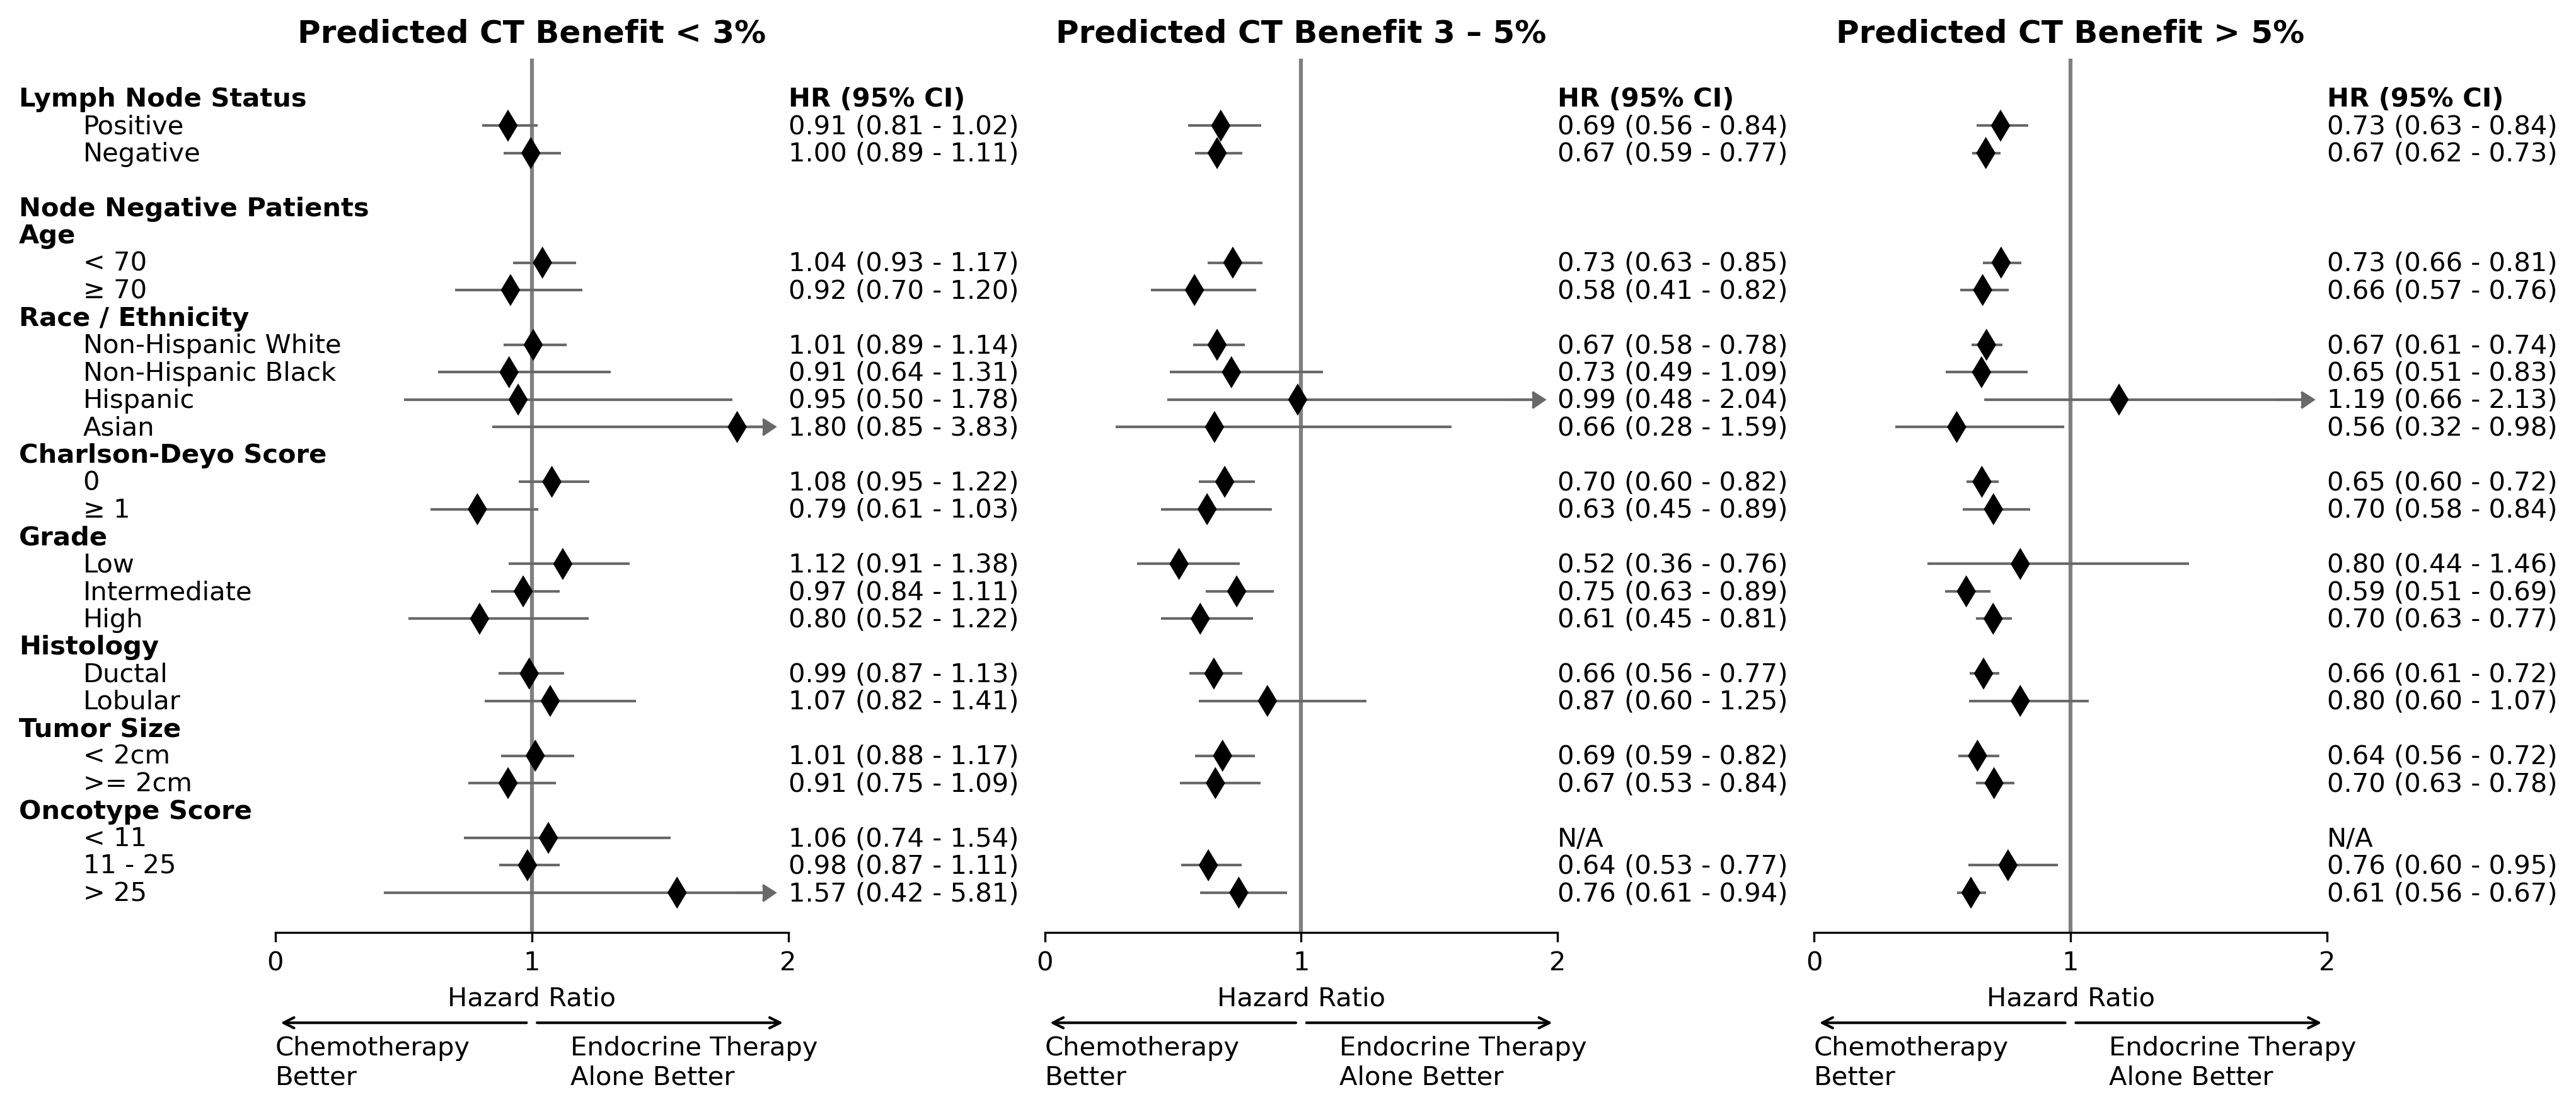

In [9]:
def getHRChemo(df, score = None, LN = 0, ageL = 0, ageU = 100, ethGroup = 4, riskLower = 0, riskUpper = 1000, cdcc = -1, grade = 0, histgroup = -1, TSL = 0, TSU = 1000, RSL = 0, RSU = 1000, covars = []):
    """Get the HR, lower bound, and upper bound for survival with versus without chemotherapy in subgroups.
    
    Parameters
    ----------
    df - dataset to calculate HR for
    score - if weighted, provide propensity score
    LN - lymph node status (0 = negative, 1 = positive)
    ageL / ageU - upper and lower bound for patient's age, inclusive
    ethGroup - which races to include (0 - white, 1 - black, 2 - hispanic, 5 - asian)
    riskLower / riskUpper - lower and upper bound for abs benefit of AI
    cdcc - -1 for all, 0 for 0, or 1 for 1
    grade - 0 for all, or 1-3 for grades 1-3 only
    TSL / TSU - lower and upper bounds for tumor size
    RSL / RSU - lower and upper bounds for recurrence score

    Returns
    -------
    Tuple of hazard ratio, lower bound, and upper bound

    """
    if LN == 1:
        df = df[(df.regional_nodes_positive.astype(float) > 0) & (df.regional_nodes_positive.astype(float) < 98)]
    if LN == 0:
        df = df[(df.regional_nodes_positive.astype(float).isin([0.0,98.0,99.0]))]
    if ethGroup != 4:
        df = df[df.race_parse == ethGroup]
    if grade > 0:
        df = df[df.grade == grade]
    if cdcc > -1:
        if cdcc == 0:
            df = df[df.cdcc == 0]
        else:
            df = df[df.cdcc == 1]
    if histgroup > -1:
        df = df[df.histology == histgroup]
    df = df[(df.tumor_size >= TSL) & (df.tumor_size < TSU)]
    df = df[(df.recurrence_score >= RSL) & (df.recurrence_score < RSU)]
    df = df[(df.age.astype(float) >= ageL) & (df.age.astype(float) <= ageU)]
    df = df[(df.absBenefitAI > riskLower) & (df.absBenefitAI <= riskUpper)]
    if len(df.index) < 10:
        return 1, 1, 1
    if cdcc != -1:
        covars.remove("cdcc")
    if score:
        cph = CoxPHFitter().fit(df[['chemo', 'last_contact', 'alive'] + [score] + covars], robust=True, duration_col='last_contact', event_col='alive', weights_col=score)
    else:
        cph = CoxPHFitter().fit(df[['chemo', 'last_contact', 'alive'] + covars], robust=True, duration_col='last_contact', event_col='alive')

    cis = cph.confidence_intervals_[cph.confidence_intervals_.index == 'chemo'].values.tolist()[0]
    ci1 = math.exp(cis[0])
    ci2 = math.exp(cis[1])
    hr = cph.hazard_ratios_['chemo']
    return hr, ci1, ci2

def getHRarray(score, covars = []):
    """Get an array of HRs, LBs, and UBs for various clinical and demographic subgroups, print to console
    
    Parameters
    ----------
    score - match on score
    """
    
    df = prepareDataset(LN = 2, ageL = 0, ncdbfile = 'NCDB2020.csv', dropna = ['age', 'cdcc', 'race_black', 'race_hispanic', 'race_other', 'insurance_parse', 'last_contact', 'grade', 'tumor_size', 'alive', 'riskTAM'])
    LNs = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ageL =[0, 0, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ageU = [200, 200, 69, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
    ethGroup = [4, 4, 4, 4, 0, 1, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
    cdccGroup = [-1, -1, -1, -1, -1, -1,  -1, -1, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    grade = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0]
    histgroup = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, -1, -1, -1] 
    TSL = [0, 0, 0 ,0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0]
    TSU = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 20, 1000, 1000, 1000, 1000]
    RSL = [0, 0, 0 ,0 , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 26]
    RSU = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 11, 26, 1000]
    labs = ["Overall LN+", "Overall LN-", "Age < 70", "Age >= 70", "Non-Hispanic White", "Non-Hispanic Black", "Hispanic", "Asian", "CDCC 0", "CDCC > 0", "Grade 1", "Grade 2", "Grade 3", "< 2cm", ">= 2cm", "Low RS", "Intermediate RS", "High RS"]
    rlList = [0, 2.99, 5.01]
    ruList = [2.99, 5, 1000]
    #Plot a pregenerated set of arrays of hazard ratios (as generation takes a long time)
    labs_top = ['Lymph Node Status', 'Positive', 'Negative', '', 'Node Negative Patients', 'Age', '< 70', '≥ 70', 'Race / Ethnicity', 'Non-Hispanic White', 'Non-Hispanic Black', 'Hispanic', 'Asian', 'Charlson-Deyo Score', '0', '≥ 1',
     'Grade', 'Low', 'Intermediate', 'High', 'Histology', 'Ductal', 'Lobular', 'Tumor Size', '< 2cm', '>= 2cm', 'Oncotype Score', '< 11', '11 - 25', '> 25']
    plt.figure(figsize=(14, 6), dpi=300)
    gspec = gridspec.GridSpec(1, 3, wspace=0.5)  # sets up grid
    axs = [plt.subplot(gspec[0, 0]), plt.subplot(gspec[0, 1]), plt.subplot(gspec[0, 2])]
    titles = ["Predicted CT Benefit < 3%", "Predicted CT Benefit 3 – 5%", "Predicted CT Benefit > 5%"]
    annotates = [True, False, False]
    for rl, ru, ax, title, an in zip(rlList ,ruList, axs, titles, annotates):
        hrs = []
        lbs = []
        ubs = []
        for a,b,c,d,e,f,g, t1,t2,r1,r2 in zip(LNs, ageL, ageU, ethGroup, cdccGroup, grade, histgroup, TSL, TSU, RSL, RSU):
            h,l,u = getHRChemo(df.copy(), score, LN = a, ageL = b, ageU = c, ethGroup = d, riskLower = rl, riskUpper = ru, cdcc =e, grade=f, histgroup = g, TSL=t1, TSU=t2, RSL=r1, RSU=r2, covars = covars.copy())
            print(h)
            hrs += [h]
            lbs += [l]
            ubs += [u]
        print(labs)
        print(hrs)
        print(lbs)
        print(ubs)
        forestPlot(ax, labs_top, hrs, lbs, ubs, title, an)
    plt.savefig('Figure 4.png', bbox_inches = "tight")
    plt.show()
    
def annotateForestOld(labs, ax, index, hrs):
    """Annotates the forest plot with specified row labels
    
    Parameters
    ----------
    labs - row labels
    ax - axis on which to annotate
    index - list of indexes to use for annotation
    hrs - list of hazard ratios / np.nan values. If nan, will annotate in bold (row heading)

    """
    for l, i, h in zip(labs, index, hrs):
        if np.isnan(h):
            ax.annotate(l, (-1, i-0.3), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False, weight='bold')
        else:
            ax.annotate(l, (-0.75, i-0.3), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)

def forestPlot(ax, labs, hrs, lbs, ubs, axTitle, annotate = False):
    """Create a forest plot
    Parameters
    ----------
    ax - axis on which to annotate
    labs - row labels
    hrs - hazard ratios
    lbs - lower bounds
    ubs - upper bounds
    axTitle - title for forest plot
    annotate - should be True for leftmost plot to allow annotating with labels
    """
    nanArray = [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
    hrs2 = []
    lbs2 = []
    ubs2 = []
    for i in nanArray:
        if i == 1:
            hrs2 += [np.nan]
            lbs2 += [np.nan]
            ubs2 += [np.nan]
        else:
            hrs2 += [hrs.pop(0)]
            lbs2 += [lbs.pop(0)]
            ubs2 += [ubs.pop(0)]
    hrs = hrs2
    lbs = lbs2
    ubs = ubs2
    for a,b,c,d in zip(hrs, lbs, ubs, list(range(len(hrs)))):
        if a == 1 and b == 1 and c == 1:
            hrs[d] = -1
            lbs[d] = -1
            ubs[d] = -1
    index = list(reversed(range(len(labs))))
    if annotate:
        annotateForestOld(labs, ax, index, hrs)
    ax.set_xlabel("Hazard Ratio")
    ax.annotate('Chemotherapy\nBetter', (0, -7), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)
    ax.annotate('Endocrine Therapy\nAlone Better', (1.15, -7), xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)
    extend_lb = []
    extend_ub = []
    extend_hr = []
    new_ubs = []
    lims_ar = []
    for lb, ub in zip(lbs, ubs):
        if ub > 2.0:
            new_ubs += [1.9]
            extend_lb += [1.8]
            extend_ub += [1.9]
            extend_hr += [1.8]
            lims_ar += [True]
        else:
            new_ubs += [ub]
            extend_lb += [1.0]
            extend_ub += [1.0]
            extend_hr += [1.0]
            lims_ar += [False]
            
    ax.errorbar(hrs, index, xerr=[[a_i - b_i for a_i, b_i in zip(hrs, lbs)], [a_i - b_i for a_i, b_i in zip(new_ubs, hrs)]], marker='None', zorder=2, ecolor="dimgrey", elinewidth=1, linewidth=0)
    ax.errorbar(extend_hr, index, xerr=[[a_i - b_i for a_i, b_i in zip(extend_hr, extend_lb)], [a_i - b_i for a_i, b_i in zip(extend_ub, extend_hr)]], marker='None', ls='--', zorder=2, ecolor="dimgrey", elinewidth=1, linewidth=0, xlolims=lims_ar)
    ax.scatter(hrs, index, c="k", s=(75), marker='d', zorder=3, edgecolors='None')
    
    ax.axvline(1, color="gray", zorder=1)
    ax.set_title(axTitle, fontweight='bold')
    offset = 2
    ax.annotate('HR (95% CI)', (offset, 29 - 0.3), xycoords='data', clip_on=False,
                visible=True, zorder=1, annotation_clip=False, weight = 'bold')
    for i, h, l, u in zip(index, hrs, lbs, ubs):
        if not np.isnan(h):
            if h != -1:
                ax.annotate('{0:.2f} ({1:.2f} - {2:.2f})'.format(h, l, u), (offset, i-0.3),  xycoords = 'data', clip_on=False, visible=True, zorder = 1, annotation_clip=False)
            else:
                ax.annotate('N/A', (offset, i - 0.3), xycoords='data',
                            clip_on=False, visible=True, zorder=1, annotation_clip=False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_yticks([])
    ax.set_xlim([0.2, 0.8])
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.annotate("", xy=(0, -4.75), xytext=(1,-4.75), arrowprops=dict(arrowstyle="->"), zorder = 1, annotation_clip=False)
    ax.annotate("", xy=(2, -4.75), xytext=(1,-4.75), arrowprops=dict(arrowstyle="->"), zorder = 1, annotation_clip=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

def getHRarraySaved():
    #Plot a pregenerated set of arrays of hazard ratios (as generation takes a long time)
    labs = ['Lymph Node Status', 'Positive', 'Negative', '', 'Node Negative Patients', 'Age', '< 70', '≥ 70', 'Race / Ethnicity', 'Non-Hispanic White', 'Non-Hispanic Black', 'Hispanic', 'Asian', 'Charlson-Deyo Score', '0', '≥ 1',
     'Grade', 'Low', 'Intermediate', 'High', 'Histology', 'Ductal', 'Lobular', 'Tumor Size', '< 2cm', '>= 2cm', 'Oncotype Score', '< 11', '11 - 25', '> 25']
    plt.figure(figsize=(14, 6), dpi=300)
    gspec = gridspec.GridSpec(1, 3, wspace=0.5)  # sets up grid

    hrs = [0.7272539863364166, 0.6698794701473834, 0.7293419178933495, 0.6575183730859975, 0.6723449666904466, 0.6531292182646333, 1.189211439198219, 0.5564099259486215, 0.6546101568014783, 0.699578646800289, 0.8042645448505208, 0.5936611436999542, 0.6984300444886197, 0.6610212619147527, 0.8040402991385823, 0.6373865239880006, 0.7018323056497356, 1, 0.7563992539146029, 0.6118005656221963]
    lbs = [0.6332977985300311, 0.6175469892466815, 0.658052952944042, 0.5691207097891254, 0.614875677111094, 0.512719274491653, 0.6628799742392081, 0.3174418294867571, 0.5955485464877888, 0.5805037731758886, 0.4426561283306947, 0.5120304665010013, 0.6323349009128993, 0.6056366466467104, 0.6030901191975816, 0.5621386438268562, 0.6304466068060515, 1, 0.6010066463142473, 0.5582650895261001]
    ubs = [0.8351495329209303, 0.7266467367484626, 0.808353842675611, 0.7596462464102686, 0.7351856172907343, 0.8319909099846325, 2.133453871106928, 0.9752716149434423, 0.7195290122271204, 0.8430785563742331, 1.4612730214374894, 0.6883058266972253, 0.7714338182822643, 0.7214707219628674, 1.0719472630375892, 0.7227070855613303, 0.7813010331660905, 1, 0.9519692250182109, 0.6704698880837685]
    ax3 = plt.subplot(gspec[0, 2])
    forestPlot(ax3, labs, hrs, lbs, ubs, "Predicted CT Benefit > 5%")

    hrs = [0.6865842290615557, 0.6723941048227462, 0.7335806401398933, 0.5840925558782645, 0.672213943949086, 0.7280722189737326, 0.9865616483202982, 0.6621875242609112, 0.702082713061511, 0.6332294759570561, 0.5238131274892156, 0.7486919833385279, 0.6064877079256954, 0.6597133269725091, 0.8685356632433375, 0.6936307554430716, 0.6656078199577856, 1, 0.638131904592127, 0.7568934809400153]
    lbs = [0.5584855587844215, 0.5871759088884235, 0.6345590632721065, 0.4137477222634833, 0.5791579671573414, 0.4880070591097277, 0.47683294558117667, 0.2763054506482304, 0.6012682367446874, 0.4523836900384933, 0.36102810843238975, 0.6272470395930231, 0.4530364549889763, 0.5642453869429044, 0.6011186690410161, 0.5867846993307141, 0.5270181340076673, 1, 0.5308801478729762, 0.6063928450085028]
    ubs = [0.8440646247363631, 0.769980214372681, 0.8480543210794776, 0.8245703733811565, 0.780221652923966, 1.086232557800245, 2.041184223858893, 1.5869839565526613, 0.819800724296563, 0.8863705258399757, 0.7599967595914124, 0.8936505882579753, 0.8119155441341115, 0.7713340398637171, 1.2549172687133303, 0.8199321240742904, 0.8406423638973124, 1, 0.7670513378394576, 0.9447468686433138]
    ax2 = plt.subplot(gspec[0, 1])
    forestPlot(ax2, labs, hrs, lbs, ubs, "Predicted CT Benefit 3 – 5%")

    hrs = [0.9072308574703944, 0.9961763499515792, 1.0416079496424349, 0.916869003244754, 1.005610131704637, 0.9113419552960129, 0.9468530453016728, 1.8008551568254985, 1.0782574916179848, 0.7878389860533772, 1.1209817836108136, 0.9664581046279012, 0.7963669339723356, 0.9900315788969196, 1.0717993528821732, 1.0135444205034527, 0.9074561530285451, 1.0647715793264163, 0.9831861007952757, 1.5664330454572968]
    lbs = [0.805578193458904, 0.8907750198822129, 0.9257243731188223, 0.7019208559332668, 0.8907090263254059, 0.6352171678099106, 0.5028873586294824, 0.8469022643545879, 0.949123587405489, 0.605460931559786, 0.9091860350541502, 0.8415473912286663, 0.5186202800197657, 0.8702903561764156, 0.8172284408480218, 0.8810063748110107, 0.7532762278000366, 0.7350609983663849, 0.8727775886408194, 0.4223552383853599]
    ubs = [1.0217106612735731, 1.1140493368730433, 1.1719980074663732, 1.1976403920828231, 1.1353334333647733, 1.3074963989816177, 1.7827664068557307, 3.8293430450755674, 1.2249608308739677, 1.0251532932877996, 1.3821155525254403, 1.1099092905953247, 1.2228605744077876, 1.1262477175082473, 1.4056704287562556, 1.1660214065466272, 1.0931934916814672, 1.542373379435061, 1.1075615613622642, 5.80959406418404]
    ax = plt.subplot(gspec[0, 0])
    forestPlot(ax, labs, hrs, lbs, ubs, "Predicted CT Benefit < 3%", True)
    plt.savefig('Figure 4.png', bbox_inches = "tight")
    plt.show()

#getHRarray("score_ACRI", covars = ['age', 'cdcc'])
getHRarraySaved()

### want to change to robust. 
### need to modify hrs, lbs (lower bounds) and ubs in get hr saved.


